# Ï∫°Ïä§ÌÜ§ ÎîîÏûêÏù∏ ÏµúÏ¢Ö Î≥¥Í≥†ÏÑú

# 0. ÌÅ¨Î°§ÎßÅ

`-` RSeleniumÏùÑ Ïù¥Ïö©Ìïú ÌÅ¨Î°§ÎßÅ ÏΩîÎìúÏûÖÎãàÎã§.

In [ ]:
library(RSelenium)
library(stringr)
library(readr)
library(rvest)
library(fs)

# Í∏∞Î≥∏ ÏÑ§Ï†ï
Sys.setenv(PATH = paste0(Sys.getenv("PATH"), ";C:/chromedriver/"))
port_num <- sample(4000:5000, 1)
driver <- rsDriver(browser = "chrome", port = port_num, chromever = NULL, verbose = FALSE, check = FALSE)
remDr <- driver$client

# Ïπ¥ÌÖåÍ≥†Î¶¨ Î∞è ÏãúÏûëÏ†ê
category_ids <- c("001001047005", "001001047007", "001001047008", "001001047009", "001001047019",
                  "001001047003", "001001047010", "001001047011", "001001047012", "001001047013",
                  "001001047014", "001001047018", "001001047004", "001001047015", "001001047016",
                  "001001047017", "001001047006", "001001047002", "001001047001")

start_info <- list("123" = list(blocks=0, page=1))

for (cat_id in category_ids) {
  block_jumps <- if (!is.null(start_info[[cat_id]])) start_info[[cat_id]]$blocks else 0
  page_num <- if (!is.null(start_info[[cat_id]])) start_info[[cat_id]]$page else 1
  
  list_dir <- file.path("C:/Users/Ï∞®ÏÉÅÏßÑ/Downloads/yes24/yes24", cat_id, "list")
  dir_create(list_dir, recurse = TRUE)
  
  url <- paste0("http://www.yes24.com/24/Category/Display/", cat_id)
  remDr$navigate(url)
  Sys.sleep(4)
  
  tryCatch({
    pg_size_selector <- remDr$findElement(using = "css selector", "#pg_size")
    pg_size_selector$sendKeysToElement(list("120"))
    Sys.sleep(5)
  }, error = function(e) {
    cat("‚ö†Ô∏è 120Í∞ú Î≥¥Í∏∞ Ïã§Ìå® (", cat_id, "): ", e$message, "\n")
  })
  
  for (i in seq_len(block_jumps)) {
    next_btns <- remDr$findElements(using = "css selector", "a.bgYUI.next")
    if (length(next_btns) > 0) {
      next_btns[[1]]$clickElement()
      Sys.sleep(3)
    }
  }
  
  if (page_num > 1) {
    page_links <- remDr$findElements("css selector", "div.yesUI_pagen a.num")
    idx <- which(sapply(page_links, function(el) el$getElementText()[[1]]) == as.character(page_num))
    if (length(idx) > 0) {
      page_links[[idx]]$clickElement()
      Sys.sleep(4)
    }
  }
  
  repeat {
    # ‚úÖ ÌòÑÏû¨ ÌéòÏù¥ÏßÄ HTML Ï†ÄÏû•
    page_source <- remDr$getPageSource()[[1]]
    list_file <- file.path(list_dir, paste0("cat_", cat_id, "_list_page_", page_num, ".html"))
    write(page_source, file = list_file)
    cat("‚úÖ Ïπ¥ÌÖåÍ≥†Î¶¨", cat_id, "ÌéòÏù¥ÏßÄ", page_num, "Ï†ÄÏû• ÏôÑÎ£å ‚Üí", list_file, "\n")
    
    next_page <- as.character(page_num + 1)
    
    # 1. ÏùºÎ∞ò Î≤àÌò∏ ÌéòÏù¥ÏßÄ ÎßÅÌÅ¨ Î®ºÏ†Ä ÌÉêÏÉâ
    page_links <- remDr$findElements(using = "css selector", "div.yesUI_pagen a.num")
    link_titles <- sapply(page_links, function(el) el$getElementAttribute("title")[[1]])
    idx <- which(link_titles == next_page)
    
    if (length(idx) > 0) {
      tryCatch({
        page_links[[idx]]$clickElement()
        Sys.sleep(3)
        page_num <- page_num + 1
      }, error = function(e) {
        cat("ÌéòÏù¥ÏßÄ", next_page, "Î°ú Ïù¥Îèô Ïã§Ìå®. Ï¢ÖÎ£å\n")
        break
      })
    } else {
      # 2. Îã§Ïùå Î∏îÎ°ù Î≤ÑÌäºÏùò titleÏù¥ Îã§Ïùå ÌéòÏù¥ÏßÄ Î≤àÌò∏Ïù∏ÏßÄ ÌôïÏù∏
      next_btns <- remDr$findElements(using = "css selector", "a.bgYUI.next")
      if (length(next_btns) > 0) {
        next_titles <- sapply(next_btns, function(el) el$getElementAttribute("title")[[1]])
        idx_next <- which(next_titles == next_page)
        
        if (length(idx_next) > 0) {
          tryCatch({
            next_btns[[idx_next]]$clickElement()
            Sys.sleep(4)
            page_num <- page_num + 1
            cat("‚û°Ô∏è Îã§Ïùå Î∏îÎ°ùÏúºÎ°ú Ïù¥Îèô: ÌéòÏù¥ÏßÄ", page_num, "\n")
          }, error = function(e) {
            cat("‚ùå Îã§Ïùå Î∏îÎ°ù ÌÅ¥Î¶≠ Ïã§Ìå®. Ï¢ÖÎ£å\n")
            break
          })
        } else {
          cat("üîö Îã§Ïùå Î∏îÎ°ù ÏóÜÏùå. Ï¢ÖÎ£å\n")
          break
        }
      } else {
        cat("üîö Îçî Ïù¥ÏÉÅ ÌéòÏù¥ÏßÄ ÏóÜÏùå. Ï¢ÖÎ£å\n")
        break
      }
    }
  }
  
} # for ÎÅù

In [ ]:
library(rvest)
library(stringr)
library(fs)

# 1. Ï†ÑÏ≤¥ Ïπ¥ÌÖåÍ≥†Î¶¨ Í≤ΩÎ°ú ÏÑ§Ï†ï
base_dir <- "C:/Users/Ï∞®ÏÉÅÏßÑ/Downloads/yes24/yes24"
category_ids <- c("001001001003", "001001001006", "001001001011", "001001001012", "001001001013",
                  "001001001001005", "001001001001007", "001001001001008", "001001001001009", "001001001001010",
                  "001001001001011", "001001001001012", "001001001001013")

# 2. Í∞Å Ïπ¥ÌÖåÍ≥†Î¶¨ ÏàúÌöå
for (cat_id in category_ids) {
  list_dir <- file.path(base_dir, cat_id, "list")
  save_dir <- file.path(base_dir, cat_id, "new_books")
  dir_create(save_dir, recurse = TRUE)
  
  # ÏòàÏô∏ ÌéòÏù¥ÏßÄ Î™©Î°ù (ÎπÑÏõåÎë†)
  excluded_pages <- c()
  excluded_pattern <- paste0("_page_(", paste(excluded_pages, collapse = "|"), ")\\.html$")
  
  # list ÌååÏùº ÌïÑÌÑ∞ÎßÅ
  list_files <- dir_ls(list_dir, glob = "*.html")
  if (length(excluded_pages) > 0) {
    list_files <- list_files[!str_detect(list_files, excluded_pattern)]
  }
  
  saved_pages <- c()  # ÌéòÏù¥ÏßÄ ÎàÑÏ†Å Ï∂îÏ†ÅÏö©
  
  for (list_path in list_files) {
    page_num <- str_match(basename(list_path), "_page_(\\d+)\\.html")[,2]
    
    # ‚úÖ ÏÉà ÌéòÏù¥ÏßÄ Í∞êÏßÄ Ïãú Ï∂úÎ†•
    if (!(page_num %in% saved_pages)) {
      saved_pages <- c(saved_pages, page_num)
      saved_pages <- sort(as.numeric(saved_pages))
      cat(sprintf("üìÑ Ï†ÄÏû•Îêú ÌéòÏù¥ÏßÄ: (%s)\n", paste(saved_pages, collapse = ", ")))
    }
    
    list_html <- tryCatch(read_html(list_path), error = function(e) NULL)
    if (is.null(list_html)) {
      cat("‚ö†Ô∏è HTML Î°úÎìú Ïã§Ìå®:", list_path, "\n")
      next
    }
    
    book_links <- list_html %>%
      html_elements("a.gd_name") %>%
      html_attr("href")
    
    book_uids <- str_match(book_links, "/product/goods/(\\d+)")[,2]
    book_uids <- na.omit(book_uids)
    
    for (i in seq_along(book_uids)) {
      book_uid <- book_uids[i]
      save_path <- file.path(save_dir, paste0("book_", book_uid, ".html"))
      
      if (file_exists(save_path)) {
        cat("‚è© Ïù¥ÎØ∏ Ï†ÄÏû•Îê®:", book_uid, "\n")
        next
      }
      
      book_url <- paste0("https://www.yes24.com/Product/Goods/", book_uid)
      
      tryCatch({
        Sys.sleep(1)
        html <- read_html(book_url)
        writeLines(as.character(html), save_path, useBytes = TRUE)
        cat(sprintf("[üìÇ%s] üìÑ %spg | üìò %02dÎ≤àÏß∏ Ï±Ö | UID: %s\n",
                    cat_id, page_num, i, book_uid))
      }, error = function(e) {
        cat(sprintf("‚ùå Ï†ÄÏû• Ïã§Ìå®: [Ïπ¥ÌÖåÍ≥†Î¶¨ %s] %sÌéòÏù¥ÏßÄÏùò %dÎ≤àÏß∏ Ï±Ö (book_uid: %s) - %s\n",
                    cat_id, page_num, i, book_uid, e$message))
      })
    }
  }
}

# 1. Imports

In [257]:
from bs4 import BeautifulSoup
import os
import re
from glob import glob
from tqdm import tqdm
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging

# 2. Parsing

In [261]:
def parse_html_from_zip(zip_file, file_name):
    with zip_file.open(file_name) as f:
        soup = BeautifulSoup(f.read().decode('utf-8'), "html.parser")

    # Í∏∞Ï°¥ Ìï≠Î™©Îì§
    title = soup.select_one("h2.gd_name")
    title = title.text.strip() if title else None

    author = soup.select_one("span.gd_auth")
    author = author.text.strip() if author else None

    publisher = soup.select_one("span.gd_pub")
    publisher = publisher.text.strip() if publisher else None

    pub_date = soup.select_one("span.gd_date")
    pub_date = pub_date.text.strip() if pub_date else None

    rating = soup.find("meta", attrs={"property": "books:rating:value"})
    rating = rating["content"] if rating else None

    price_tag = soup.select_one("span.nor_price em.yes_m")
    price = price_tag.text.strip().replace(",", "") if price_tag else None

    page_count = book_size = None
    info_th = soup.find("th", string=lambda s: s and "Ï™ΩÏàò" in s)
    if info_th:
        td = info_th.find_next_sibling("td")
        if td:
            text = td.get_text(strip=True)
            parts = text.split("|")
            page_count = parts[0].strip() if len(parts) > 0 else None
            book_size = parts[1].strip() if len(parts) > 1 else None

    intro_wrap = soup.select_one("#infoset_introduce .infoWrap_txt")
    book_intro = intro_wrap.get_text(strip=True) if intro_wrap else None

    toc_wrap = soup.select_one("#infoset_toc .infoWrap_txt")
    table_of_contents = toc_wrap.get_text(strip=True) if toc_wrap else None

    sales_rank_tag = soup.select_one("span.sell_score strong")
    sales_rank = sales_rank_tag.get_text(strip=True) if sales_rank_tag else None

    th = soup.find("th", string="ISBN13")
    isbn13 = th.find_next_sibling("td").get_text(strip=True) if th else None

    th = soup.find("th", string="ISBN10")
    isbn10 = th.find_next_sibling("td").get_text(strip=True) if th else None

    category_items = soup.select("div.location_area a")
    category_path = " > ".join([item.get_text(strip=True) for item in category_items]) if category_items else None

    event_items = soup.select("div#event_infoWrap div.event_info_text")
    events = [item.get_text(strip=True) for item in event_items] if event_items else []

    # ‚úÖ Î∞∞ÏÜ°Î£å Ï∂îÏ∂ú (Ïòà: 'Î∞∞ÏÜ°ÎπÑ : Î¨¥Î£åÎ∞∞ÏÜ°')
    shipping_fee = None
    shipping_section = soup.find("th", string=lambda s: s and "Î∞∞ÏÜ° Íµ¨Î∂Ñ" in s)
    if shipping_section:
        td = shipping_section.find_next_sibling("td")
        if td:
            text = td.get_text(separator=" ", strip=True)
            # 'Î∞∞ÏÜ°ÎπÑ : Î¨¥Î£åÎ∞∞ÏÜ°'Í≥º Í∞ôÏùÄ Î¨∏Ïû•ÏóêÏÑú 'Î¨¥Î£åÎ∞∞ÏÜ°' ÎòêÎäî Í∞ÄÍ≤© Ï∂îÏ∂ú
            match = re.search(r'Î∞∞ÏÜ°ÎπÑ\s*[:Ôºö]?\s*([^\s]+)', text)
            if match:
                shipping_fee = match.group(1)


    # Í≤∞Í≥º Î∞òÌôò
    return {
        "ÌååÏùºÍ≤ΩÎ°ú": file_name,
        "Ïπ¥ÌÖåÍ≥†Î¶¨": file_name.split("/")[1] if "/" in file_name else None,
        "Ï†úÎ™©": title,
        "Ï†ÄÏûê": author,
        "Ï∂úÌåêÏÇ¨": publisher,
        "Ï∂úÌåêÏùº": pub_date,
        "Î≥ÑÏ†ê": rating,
        "Í∞ÄÍ≤©": price,
        "Ï™ΩÏàò": page_count,
        "Ï±ÖÌÅ¨Í∏∞": book_size,
        "Ï±ÖÏÜåÍ∞ú": book_intro,
        "Î™©Ï∞®": table_of_contents,
        "ÌåêÎß§ÏßÄÏàò": sales_rank,
        "ISBN13": isbn13,
        "ISBN10": isbn10,
        "Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò": category_path,
        "Ïù¥Î≤§Ìä∏": events,
        "Î∞∞ÏÜ°Î£å": shipping_fee
    }

In [262]:
def parse_books_in_zip(zip_path):
    results = []
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        html_files = [f for f in zip_file.namelist()
                      if f.endswith(".html")
                      and not f.startswith("__MACOSX/")
                      and not os.path.basename(f).startswith("._")]

        for idx, file_name in enumerate(tqdm(html_files, desc=f"{os.path.basename(zip_path)} ÌååÏã± Ï§ë"), 1):
            try:
                data = parse_html_from_zip(zip_file, file_name)
                results.append(data)
                if idx % 500 == 0:
                    print(f"‚úÖ [{idx}] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...")
            except Exception as e:
                print(f"‚ùå [{idx}] Ïã§Ìå®: {file_name} - {e}")

    return pd.DataFrame(results)

In [263]:
# zip ÌååÏùº Í≤ΩÎ°ú Î¶¨Ïä§Ìä∏
zip_dir = "."  # ÌòÑÏû¨ ÎîîÎ†âÌÜ†Î¶¨
zip_files = sorted(glob(os.path.join(zip_dir, "*.zip")))

# Í≤∞Í≥º Ï†ÄÏû•Ïö© ÎîïÏÖîÎÑàÎ¶¨
dfs = {}  # Ïòà: {'001001001013': DataFrame, ...}

for zip_path in zip_files:
    zip_filename = os.path.basename(zip_path)
    category_id = os.path.splitext(zip_filename)[0]  # '001001001013' ‚Üê from '001001001013.zip'

    print(f"\nüì¶ {category_id} ÌååÏã± ÏãúÏûë")
    df = parse_books_in_zip(zip_path)
    dfs[category_id] = df
    print(f"‚úÖ {category_id} ÏôÑÎ£å: {len(df)}Í∞ú Ìï≠Î™©")


üì¶ 001001001001005 ÌååÏã± ÏãúÏûë


001001001001005.zip ÌååÏã± Ï§ë:  27%|‚ñà‚ñà‚ñã       | 501/1849 [01:30<04:23,  5.12it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001005.zip ÌååÏã± Ï§ë:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 1001/1849 [03:01<02:19,  6.07it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001005.zip ÌååÏã± Ï§ë:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 1501/1849 [04:32<01:01,  5.70it/s]

‚úÖ [1500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001005.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1849/1849 [05:39<00:00,  5.44it/s]


‚úÖ 001001001001005 ÏôÑÎ£å: 1849Í∞ú Ìï≠Î™©

üì¶ 001001001001007 ÌååÏã± ÏãúÏûë


001001001001007.zip ÌååÏã± Ï§ë:  40%|‚ñà‚ñà‚ñà‚ñâ      | 501/1265 [01:37<02:26,  5.23it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001007.zip ÌååÏã± Ï§ë:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 1000/1265 [03:14<00:46,  5.76it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001007.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1265/1265 [04:06<00:00,  5.12it/s]


‚úÖ 001001001001007 ÏôÑÎ£å: 1265Í∞ú Ìï≠Î™©

üì¶ 001001001001008 ÌååÏã± ÏãúÏûë


001001001001008.zip ÌååÏã± Ï§ë:  21%|‚ñà‚ñà        | 501/2399 [01:38<05:41,  5.55it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001008.zip ÌååÏã± Ï§ë:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1001/2399 [03:13<04:31,  5.14it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001008.zip ÌååÏã± Ï§ë:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 1501/2399 [04:46<02:45,  5.41it/s]

‚úÖ [1500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001008.zip ÌååÏã± Ï§ë:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 2001/2399 [06:18<01:11,  5.58it/s]

‚úÖ [2000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001008.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2399/2399 [07:33<00:00,  5.30it/s]


‚úÖ 001001001001008 ÏôÑÎ£å: 2399Í∞ú Ìï≠Î™©

üì¶ 001001001001009 ÌååÏã± ÏãúÏûë


001001001001009.zip ÌååÏã± Ï§ë:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 501/886 [01:36<01:14,  5.15it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001009.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 886/886 [02:56<00:00,  5.03it/s]


‚úÖ 001001001001009 ÏôÑÎ£å: 886Í∞ú Ìï≠Î™©

üì¶ 001001001001010 ÌååÏã± ÏãúÏûë


001001001001010.zip ÌååÏã± Ï§ë:  27%|‚ñà‚ñà‚ñã       | 501/1823 [01:43<04:25,  4.98it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001010.zip ÌååÏã± Ï§ë:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 1001/1823 [03:28<02:34,  5.33it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001010.zip ÌååÏã± Ï§ë:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 1501/1823 [05:12<01:02,  5.15it/s]

‚úÖ [1500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001010.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1823/1823 [06:19<00:00,  4.80it/s]


‚úÖ 001001001001010 ÏôÑÎ£å: 1823Í∞ú Ìï≠Î™©

üì¶ 001001001001011 ÌååÏã± ÏãúÏûë


001001001001011.zip ÌååÏã± Ï§ë:  40%|‚ñà‚ñà‚ñà‚ñà      | 501/1244 [01:44<02:46,  4.47it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001011.zip ÌååÏã± Ï§ë:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 1001/1244 [03:28<00:47,  5.07it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001011.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1244/1244 [04:17<00:00,  4.84it/s]


‚úÖ 001001001001011 ÏôÑÎ£å: 1244Í∞ú Ìï≠Î™©

üì¶ 001001001001012 ÌååÏã± ÏãúÏûë


001001001001012.zip ÌååÏã± Ï§ë:  38%|‚ñà‚ñà‚ñà‚ñä      | 500/1304 [01:35<02:20,  5.72it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001012.zip ÌååÏã± Ï§ë:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 1001/1304 [03:12<01:02,  4.86it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001001012.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1304/1304 [04:10<00:00,  5.21it/s]


‚úÖ 001001001001012 ÏôÑÎ£å: 1304Í∞ú Ìï≠Î™©

üì¶ 001001001001013 ÌååÏã± ÏãúÏûë


001001001001013.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 485/485 [01:30<00:00,  5.37it/s]


‚úÖ 001001001001013 ÏôÑÎ£å: 485Í∞ú Ìï≠Î™©

üì¶ 001001001003 ÌååÏã± ÏãúÏûë


001001001003.zip ÌååÏã± Ï§ë:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 501/1039 [01:34<01:47,  5.01it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001003.zip ÌååÏã± Ï§ë:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 1001/1039 [03:08<00:07,  4.91it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001003.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1039/1039 [03:15<00:00,  5.31it/s]


‚úÖ 001001001003 ÏôÑÎ£å: 1039Í∞ú Ìï≠Î™©

üì¶ 001001001006 ÌååÏã± ÏãúÏûë


001001001006.zip ÌååÏã± Ï§ë:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 501/1098 [01:32<01:45,  5.66it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001006.zip ÌååÏã± Ï§ë:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 1001/1098 [03:04<00:18,  5.30it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001006.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1098/1098 [03:22<00:00,  5.42it/s]


‚úÖ 001001001006 ÏôÑÎ£å: 1098Í∞ú Ìï≠Î™©

üì¶ 001001001011 ÌååÏã± ÏãúÏûë


001001001011.zip ÌååÏã± Ï§ë:  14%|‚ñà‚ñç        | 501/3600 [01:35<10:45,  4.80it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001011.zip ÌååÏã± Ï§ë:  28%|‚ñà‚ñà‚ñä       | 1001/3600 [03:12<08:56,  4.84it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001011.zip ÌååÏã± Ï§ë:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 1501/3600 [04:48<06:38,  5.26it/s]

‚úÖ [1500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001011.zip ÌååÏã± Ï§ë:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2001/3600 [06:24<04:48,  5.54it/s]

‚úÖ [2000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001011.zip ÌååÏã± Ï§ë:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 2501/3600 [08:01<03:26,  5.33it/s]

‚úÖ [2500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001011.zip ÌååÏã± Ï§ë:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 3001/3600 [09:37<01:43,  5.78it/s]

‚úÖ [3000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001011.zip ÌååÏã± Ï§ë:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 3501/3600 [11:14<00:18,  5.29it/s]

‚úÖ [3500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001011.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3600/3600 [11:33<00:00,  5.19it/s]


‚úÖ 001001001011 ÏôÑÎ£å: 3600Í∞ú Ìï≠Î™©

üì¶ 001001001012 ÌååÏã± ÏãúÏûë


001001001012.zip ÌååÏã± Ï§ë:   9%|‚ñâ         | 501/5661 [01:38<19:07,  4.50it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë:  18%|‚ñà‚ñä        | 1001/5661 [03:16<15:33,  4.99it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë:  26%|‚ñà‚ñà‚ñã       | 1500/5661 [04:56<12:43,  5.45it/s]

‚úÖ [1500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë:  35%|‚ñà‚ñà‚ñà‚ñå      | 2001/5661 [06:43<12:00,  5.08it/s]

‚úÖ [2000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2501/5661 [08:30<09:57,  5.29it/s]

‚úÖ [2500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 3001/5661 [10:16<08:41,  5.10it/s]

‚úÖ [3000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3501/5661 [12:03<08:23,  4.29it/s]

‚úÖ [3500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 4001/5661 [13:50<05:20,  5.17it/s]

‚úÖ [4000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4501/5661 [15:38<03:46,  5.12it/s]

‚úÖ [4500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 5001/5661 [17:18<01:55,  5.70it/s]

‚úÖ [5000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 5501/5661 [18:57<00:27,  5.85it/s]

‚úÖ [5500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001012.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5661/5661 [19:29<00:00,  4.84it/s]


‚úÖ 001001001012 ÏôÑÎ£å: 5661Í∞ú Ìï≠Î™©

üì¶ 001001001013 ÌååÏã± ÏãúÏûë


001001001013.zip ÌååÏã± Ï§ë:  20%|‚ñà‚ñà        | 501/2474 [01:35<05:45,  5.72it/s]

‚úÖ [500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001013.zip ÌååÏã± Ï§ë:  40%|‚ñà‚ñà‚ñà‚ñà      | 1001/2474 [03:11<04:11,  5.86it/s]

‚úÖ [1000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001013.zip ÌååÏã± Ï§ë:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 1501/2474 [04:47<03:03,  5.30it/s]

‚úÖ [1500] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001013.zip ÌååÏã± Ï§ë:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 2001/2474 [06:23<01:22,  5.74it/s]

‚úÖ [2000] ÌååÏùº ÌååÏã± ÏÑ±Í≥µ Ï§ë...


001001001013.zip ÌååÏã± Ï§ë: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2474/2474 [07:54<00:00,  5.21it/s]

‚úÖ 001001001013 ÏôÑÎ£å: 2474Í∞ú Ìï≠Î™©


In [279]:
all_rows = []

for category_id, df in dfs.items():
    df = df.copy()
    df['Ïπ¥ÌÖåÍ≥†Î¶¨ID'] = category_id  # ÏÉàÎ°úÏö¥ Ïó¥ Ï∂îÍ∞Ä
    all_rows.append(df)

# ÌïòÎÇòÏùò ÌÜµÌï© DataFrame ÏÉùÏÑ±
merged_df = pd.concat(all_rows, ignore_index=True)
merged_df

ÌååÏùºÍ≤ΩÎ°ú                 Ïπ¥ÌÖåÍ≥†Î¶¨  \
0        001001001001005/book_8644853.html    book_8644853.html   
1      001001001001005/book_142251966.html  book_142251966.html   
2        001001001001005/book_1812075.html    book_1812075.html   
3      001001001001005/book_124840591.html  book_124840591.html   
4      001001001001005/book_146738659.html  book_146738659.html   
...                                    ...                  ...   
25122     001001001013/book_123379698.html  book_123379698.html   
25123      001001001013/book_18884207.html   book_18884207.html   
25124       001001001013/book_2496255.html    book_2496255.html   
25125      001001001013/book_89220860.html   book_89220860.html   
25126      001001001013/book_28884488.html   book_28884488.html   

                            Ï†úÎ™©  \
0                    ÌïúÍµ≠Ïùò ÏûêÏó∞ ÏïΩÏà†   
1                       Ïª§ÌîºÏùò Í∏∞Î≥∏   
2              Ïù¥Ïó∞ÏûêÏùò Ïö∞Î¶¨ Ï∞® Ïö∞Î¶¨ ÍΩÉÏ∞®   
3      Ìïú Í∂åÏúºÎ°ú ÎÅùÎÇ¥Îäî ÏôÄÏù∏ÌäπÍ∞ï 2 (ÌÅ∞Í∏ÄÏûêÏ±Ö)   
4            ÏôÄÏù∏Ïù¥ ÏûàÎäî 100Í∞ÄÏßÄ Ïû•Î©¥ 2   
...                        ...   
25122                ÌîåÎùºÏõå ÏóÖÏÇ¨Ïù¥ÌÅ¥ÎßÅ   
25123          Î∂ÄÏûêÎêòÎäî ÎïÖ ÌñâÎ≥µÌïú Ïßë Ï∞æÍ∏∞   
25124             Îã¨ÏΩ§ ÏåâÏã∏Î¶ÑÌïú Ï†ÑÏõêÏÉùÌôú   
25125                ÌÖÉÎ∞≠ Ï±ÑÏÜå Í∏∞Î•¥Í∏∞   
25126                 ÏïΩÏ¥à ÌÖÉÎ∞≠Í∞ÄÍæ∏Í∏∞   

                                                      Ï†ÄÏûê       Ï∂úÌåêÏÇ¨  \
0                                           ÏûêÏó∞ÏùÑ Îã¥Îäî ÏÇ¨ÎûåÎì§ Ï†Ä     ÏïÑÏù¥ÌÖúÎ∂ÅÏä§   
1      Î∞ïÎ≥¥Í∑º, ÍπÄÏÑ†Ìôî, ÍπÄÏ†ïÏßÑ, ÎßàÏãúÏó∞, ÏÑúÏ≤úÏö∞ Ï†Ä Ïô∏ 2Î™Ö\r\r\n          ...     Î∞±ÏÇ∞Ï∂úÌåêÏÇ¨   
2                                                  Ïù¥Ïó∞Ïûê Ï†Ä  ÎûúÎç§ÌïòÏö∞Ïä§ÏΩîÎ¶¨ÏïÑ   
3                                           Ï†ÑÏÉÅÌóå Ï†Ä/ÍπÄÏ§ÄÏ≤† Í∞êÏàò        ÏòàÎ¨∏   
4                                      ÏóÑÏ†ïÏÑ†, Î∞∞ÎëêÌôò Ï†Ä/ÍπÄÏßÄÌù¨ Í∑∏Î¶º     Î≥¥ÌãÄÌîÑÎ†àÏä§   
...                                                  ...       ...   
25122                                              ÎØºÏÜåÌù¨ Ï†Ä       ÌîåÎ°úÎùº   
25123                                              ÍπÄÏòÅÏÑù Ï†Ä       ÏùºÏßÑÏÇ¨   
25124                                           Ìô©Ìò∏Í≥§ Ïô∏ Í≥µÏ†Ä  ÎÜçÏ¥åÏ†ïÎ≥¥Î¨∏ÌôîÏÑºÌÑ∞   
25125                                         ÌôçÍ∑úÌòÑ, ÏÑúÎ™ÖÌõà Ï†Ä     Í∞ÄÍµêÏ∂úÌåêÏÇ¨   
25126                                              ÏÜêÌòÑÌÉù Ï†Ä      ÏßÄÏãùÏÑúÍ¥Ä   

                 Ï∂úÌåêÏùº  Î≥ÑÏ†ê     Í∞ÄÍ≤©    Ï™ΩÏàò           Ï±ÖÌÅ¨Í∏∞  \
0      2013ÎÖÑ 03Ïõî 20Ïùº  10   7200  240Ï™Ω          258g   
1      2025ÎÖÑ 02Ïõî 28Ïùº   0  20000  204Ï™Ω  188*254*20mm   
2      2005ÎÖÑ 11Ïõî 24Ïùº   0  16200  171Ï™Ω          780g   
3      2024ÎÖÑ 02Ïõî 01Ïùº   0  42000  232Ï™Ω  210*290*20mm   
4      2025ÎÖÑ 05Ïõî 21Ïùº   0  25200  520Ï™Ω  128*225*35mm   
...              ...  ..    ...   ...           ...   
25122  2023ÎÖÑ 11Ïõî 10Ïùº   0  14400  144Ï™Ω  150*200*20mm   
25123  2015ÎÖÑ 05Ïõî 15Ïùº   0  25200  434Ï™Ω  188*254*30mm   
25124  2007ÎÖÑ 03Ïõî 02Ïùº   9  16150  307Ï™Ω          760g   
25125  2020ÎÖÑ 02Ïõî 25Ïùº  10  20900  352Ï™Ω          594g   
25126  2016ÎÖÑ 06Ïõî 20Ïùº   0  20250  448Ï™Ω          720g   

                                                     Ï±ÖÏÜåÍ∞ú  \
0      Ïö∞Î¶¨ÎÇòÎùºÏùò ÏïΩÏà†ÏùÑ ÏÜåÍ∞úÌñàÎã§. Ïó¨Îü¨ Í∞ÄÏßÄ Í≥ºÏã§ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÎßåÎì† Í≥ºÏã§Ï£ºÏôÄ ÎçîÎ∂àÏñ¥ Ïûé, ...   
1      Î∞îÎ¶¨Ïä§ÌÉÄÏóê Í¥ÄÏã¨ ÏûàÎäî Ïù¥Îì§ÏóêÍ≤å Ïù¥Î°†ÏóêÎèÑ ÎèÑÏõÄÏù¥ ÎêòÍ≥† Ïã§Î¨¥ÏóêÎèÑ ÎèÑÏõÄÏù¥ ÎêòÎäî Ï±ÖÏùÑ ÎßåÎì§...   
2      ÌïúÎ∞∞Îã¨ Ïö∞Î¶¨Ï∞®Î¨∏ÌôîÏõêÏû• Ïù¥Ïó∞Ïûê ÏõêÏû•Ïù¥ ÏûêÏã†Ïùò 30ÎÖÑ Ï∞® Ïù∏ÏÉùÏùÑ Í≥†Ïä§ÎûÄÌûà Îã¥ÏïÑ Ïö∞Î¶¨ ÎïÖ...   
3      15ÎÖÑÍ∞Ñ Î∂ÄÎèôÏùò Î≤†Ïä§Ìä∏ÏÖÄÎü¨!ÏôÄÏù∏ Î∂ÑÏïº Ï†ÑÎ¨∏Í∞ÄÎì§Ïù¥ ÏÑ†ÌÉùÌï¥Ïò® ÎåÄÌïúÎØºÍµ≠ ÏµúÍ≥†Ïùò ÏôÄÏù∏ ÍµêÍ≥º...   
4      ‚ÄòÏ†Ä Ïû•Î©¥ÏóêÏÑú Ïó¨ÏûêÍ∞Ä ÎÇ®ÏûêÏóêÍ≤å Í±¥ÎÑ® ÏôÄÏù∏ Î≠êÏßÄ?‚ÄôÏòÅÌôîÎ•º Î≥¥Îã§Í∞Ä Í∂ÅÍ∏àÌñàÏùÑ ÏôÄÏù∏Îü¨Î≤ÑÎ•º ...   
...                                                 

# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

`-` Ïπ¥ÌÖåÍ≥†Î¶¨ ÌïúÍ∏ÄÌôî

In [348]:
category_dct = {
    '001001001003' : 'ÏûÑÏã†/Ï∂úÏÇ∞',
    '001001001011': 'Ïú°ÏïÑ',
    '001001001012': 'ÏûêÎÖÄÍµêÏú°',
    '001001001001007': 'ÏöîÎ¶¨ÏùºÎ∞ò',
    '001001001001008': 'ÏÉùÌôúÏöîÎ¶¨',
    '001001001001009': 'Í∞úÏù∏ÏöîÎ¶¨Ï±Ö',
    '001001001001010': 'ÏÉÅÌô©Î≥ÑÏöîÎ¶¨',
    '001001001001011': 'Î©îÎâ¥Î≥Ñ/ÎÇòÎùºÎ≥ÑÏöîÎ¶¨',
    '001001001001012': 'ÌôàÎ≤†Ïù¥ÌÇπ/Î≤†Ïù¥Ïª§Î¶¨',
    '001001001001013': 'ÌïúÍµ≠Ï†ÑÌÜµÏöîÎ¶¨',
    '001001001001005': 'Ï∞®/Ïà†/ÏùåÎ£å',
    '001001001013': 'Ïßë/ÏÇ¥Î¶º',
    '001001001006': 'Í≤∞Ìòº/Í∞ÄÏ°±'
}

merged_df['Ïπ¥ÌÖåÍ≥†Î¶¨'] = merged_df['Ïπ¥ÌÖåÍ≥†Î¶¨ID'].map(category_dct)

`-` Ï§ëÎ≥µÎêòÎäî Ïó¥ ÏÇ≠Ï†ú

In [349]:
df = merged_df.drop(columns = 'Ïπ¥ÌÖåÍ≥†Î¶¨ID')
df

ÌååÏùºÍ≤ΩÎ°ú    Ïπ¥ÌÖåÍ≥†Î¶¨                       Ï†úÎ™©  \
0        001001001001005/book_8644853.html  Ï∞®/Ïà†/ÏùåÎ£å                ÌïúÍµ≠Ïùò ÏûêÏó∞ ÏïΩÏà†   
1      001001001001005/book_142251966.html  Ï∞®/Ïà†/ÏùåÎ£å                   Ïª§ÌîºÏùò Í∏∞Î≥∏   
2        001001001001005/book_1812075.html  Ï∞®/Ïà†/ÏùåÎ£å          Ïù¥Ïó∞ÏûêÏùò Ïö∞Î¶¨ Ï∞® Ïö∞Î¶¨ ÍΩÉÏ∞®   
3      001001001001005/book_124840591.html  Ï∞®/Ïà†/ÏùåÎ£å  Ìïú Í∂åÏúºÎ°ú ÎÅùÎÇ¥Îäî ÏôÄÏù∏ÌäπÍ∞ï 2 (ÌÅ∞Í∏ÄÏûêÏ±Ö)   
4      001001001001005/book_146738659.html  Ï∞®/Ïà†/ÏùåÎ£å        ÏôÄÏù∏Ïù¥ ÏûàÎäî 100Í∞ÄÏßÄ Ïû•Î©¥ 2   
...                                    ...     ...                      ...   
25122     001001001013/book_123379698.html    Ïßë/ÏÇ¥Î¶º                ÌîåÎùºÏõå ÏóÖÏÇ¨Ïù¥ÌÅ¥ÎßÅ   
25123      001001001013/book_18884207.html    Ïßë/ÏÇ¥Î¶º          Î∂ÄÏûêÎêòÎäî ÎïÖ ÌñâÎ≥µÌïú Ïßë Ï∞æÍ∏∞   
25124       001001001013/book_2496255.html    Ïßë/ÏÇ¥Î¶º             Îã¨ÏΩ§ ÏåâÏã∏Î¶ÑÌïú Ï†ÑÏõêÏÉùÌôú   
25125      001001001013/book_89220860.html    Ïßë/ÏÇ¥Î¶º                ÌÖÉÎ∞≠ Ï±ÑÏÜå Í∏∞Î•¥Í∏∞   
25126      001001001013/book_28884488.html    Ïßë/ÏÇ¥Î¶º                 ÏïΩÏ¥à ÌÖÉÎ∞≠Í∞ÄÍæ∏Í∏∞   

                                                      Ï†ÄÏûê       Ï∂úÌåêÏÇ¨  \
0                                           ÏûêÏó∞ÏùÑ Îã¥Îäî ÏÇ¨ÎûåÎì§ Ï†Ä     ÏïÑÏù¥ÌÖúÎ∂ÅÏä§   
1      Î∞ïÎ≥¥Í∑º, ÍπÄÏÑ†Ìôî, ÍπÄÏ†ïÏßÑ, ÎßàÏãúÏó∞, ÏÑúÏ≤úÏö∞ Ï†Ä Ïô∏ 2Î™Ö\r\r\n          ...     Î∞±ÏÇ∞Ï∂úÌåêÏÇ¨   
2                                                  Ïù¥Ïó∞Ïûê Ï†Ä  ÎûúÎç§ÌïòÏö∞Ïä§ÏΩîÎ¶¨ÏïÑ   
3                                           Ï†ÑÏÉÅÌóå Ï†Ä/ÍπÄÏ§ÄÏ≤† Í∞êÏàò        ÏòàÎ¨∏   
4                                      ÏóÑÏ†ïÏÑ†, Î∞∞ÎëêÌôò Ï†Ä/ÍπÄÏßÄÌù¨ Í∑∏Î¶º     Î≥¥ÌãÄÌîÑÎ†àÏä§   
...                                                  ...       ...   
25122                                              ÎØºÏÜåÌù¨ Ï†Ä       ÌîåÎ°úÎùº   
25123                                              ÍπÄÏòÅÏÑù Ï†Ä       ÏùºÏßÑÏÇ¨   
25124                                           Ìô©Ìò∏Í≥§ Ïô∏ Í≥µÏ†Ä  ÎÜçÏ¥åÏ†ïÎ≥¥Î¨∏ÌôîÏÑºÌÑ∞   
25125                                         ÌôçÍ∑úÌòÑ, ÏÑúÎ™ÖÌõà Ï†Ä     Í∞ÄÍµêÏ∂úÌåêÏÇ¨   
25126                                              ÏÜêÌòÑÌÉù Ï†Ä      ÏßÄÏãùÏÑúÍ¥Ä   

                 Ï∂úÌåêÏùº  Î≥ÑÏ†ê     Í∞ÄÍ≤©    Ï™ΩÏàò           Ï±ÖÌÅ¨Í∏∞  \
0      2013ÎÖÑ 03Ïõî 20Ïùº  10   7200  240Ï™Ω          258g   
1      2025ÎÖÑ 02Ïõî 28Ïùº   0  20000  204Ï™Ω  188*254*20mm   
2      2005ÎÖÑ 11Ïõî 24Ïùº   0  16200  171Ï™Ω          780g   
3      2024ÎÖÑ 02Ïõî 01Ïùº   0  42000  232Ï™Ω  210*290*20mm   
4      2025ÎÖÑ 05Ïõî 21Ïùº   0  25200  520Ï™Ω  128*225*35mm   
...              ...  ..    ...   ...           ...   
25122  2023ÎÖÑ 11Ïõî 10Ïùº   0  14400  144Ï™Ω  150*200*20mm   
25123  2015ÎÖÑ 05Ïõî 15Ïùº   0  25200  434Ï™Ω  188*254*30mm   
25124  2007ÎÖÑ 03Ïõî 02Ïùº   9  16150  307Ï™Ω          760g   
25125  2020ÎÖÑ 02Ïõî 25Ïùº  10  20900  352Ï™Ω          594g   
25126  2016ÎÖÑ 06Ïõî 20Ïùº   0  20250  448Ï™Ω          720g   

                                                     Ï±ÖÏÜåÍ∞ú  \
0      Ïö∞Î¶¨ÎÇòÎùºÏùò ÏïΩÏà†ÏùÑ ÏÜåÍ∞úÌñàÎã§. Ïó¨Îü¨ Í∞ÄÏßÄ Í≥ºÏã§ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÎßåÎì† Í≥ºÏã§Ï£ºÏôÄ ÎçîÎ∂àÏñ¥ Ïûé, ...   
1      Î∞îÎ¶¨Ïä§ÌÉÄÏóê Í¥ÄÏã¨ ÏûàÎäî Ïù¥Îì§ÏóêÍ≤å Ïù¥Î°†ÏóêÎèÑ ÎèÑÏõÄÏù¥ ÎêòÍ≥† Ïã§Î¨¥ÏóêÎèÑ ÎèÑÏõÄÏù¥ ÎêòÎäî Ï±ÖÏùÑ ÎßåÎì§...   
2      ÌïúÎ∞∞Îã¨ Ïö∞Î¶¨Ï∞®Î¨∏ÌôîÏõêÏû• Ïù¥Ïó∞Ïûê ÏõêÏû•Ïù¥ ÏûêÏã†Ïùò 30ÎÖÑ Ï∞® Ïù∏ÏÉùÏùÑ Í≥†Ïä§ÎûÄÌûà Îã¥ÏïÑ Ïö∞Î¶¨ ÎïÖ...   
3      15ÎÖÑÍ∞Ñ Î∂ÄÎèôÏùò Î≤†Ïä§Ìä∏ÏÖÄÎü¨!ÏôÄÏù∏ Î∂ÑÏïº Ï†ÑÎ¨∏Í∞ÄÎì§Ïù¥ ÏÑ†ÌÉùÌï¥Ïò® ÎåÄÌïúÎØºÍµ≠ ÏµúÍ≥†Ïùò ÏôÄÏù∏ ÍµêÍ≥º...   
4      ‚ÄòÏ†Ä Ïû•Î©¥ÏóêÏÑú Ïó¨ÏûêÍ∞Ä ÎÇ®ÏûêÏóêÍ≤å Í±¥ÎÑ® ÏôÄÏù∏ Î≠êÏßÄ?‚ÄôÏòÅÌôîÎ•º Î≥¥Îã§Í∞Ä Í∂ÅÍ∏àÌñàÏùÑ ÏôÄÏù∏Îü¨Î≤ÑÎ•º ...   
...                                                  ...   
25122  ‚ÄòÏì∏Î™®ÏóÜÏùå‚ÄôÏóêÏÑú Ïì∏Î™®Î•º Ï∞æÏïÑÎÇ¥Îäî ÌîåÎùºÏõå ÎîîÏûêÏù∏Î∂ÅÎß§Ïùº ÎßåÎì§Ïñ¥ÏßÄÎäî Ïì∞Î†àÍ∏∞Î•º ÏÉàÌôúÏö© ÌïòÎäî...   
25123                                              

`-` Ï∂úÌåêÏùº Î¨∏ÏûêÏó¥ÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôò

In [350]:
df['Ï∂úÌåêÏùº'] = pd.to_datetime(df['Ï∂úÌåêÏùº'], format="%YÎÖÑ %mÏõî %dÏùº", errors='coerce')

---

# 3. ÏÜåÏ£ºÏ†ú

## 3-1. ISBNÏù¥ Í∞ôÏùÄ Í≤ÉÏù¥ 7807Í∞ú

`-` **Data**

Ï†ÑÏ≤¥ ÎèÑÏÑúÍ∞Ä 25000Í∞ú Ï†ïÎèÑÏù∏Îç∞ 7800Í∞úÍ∞Ä Ï§ëÎ≥µÏù¥Îã§?

In [353]:
duplicate_isbn = df[df.duplicated(subset=['ISBN13', 'ISBN10'], keep=False)]

print(f"ISBN13 + ISBN10 Ï§ëÎ≥µ Ìñâ Ïàò: {len(duplicate_isbn)}Í∞ú")
display(duplicate_isbn.sort_values(by=['ISBN13', 'ISBN10']))

ISBN13 + ISBN10 Ï§ëÎ≥µ Ìñâ Ïàò: 7807Í∞ú


ÌååÏùºÍ≤ΩÎ°ú   Ïπ¥ÌÖåÍ≥†Î¶¨  \
7516   001001001001010/book_93999215.html  ÏÉÅÌô©Î≥ÑÏöîÎ¶¨   
15543     001001001011/book_93999215.html     Ïú°ÏïÑ   
15742      001001001011/book_2547843.html     Ïú°ÏïÑ   
20687      001001001012/book_2547843.html   ÏûêÎÖÄÍµêÏú°   
18564     001001001012/book_50313134.html   ÏûêÎÖÄÍµêÏú°   
...                                   ...    ...   
25054     001001001013/book_89226035.html   Ïßë/ÏÇ¥Î¶º   
25074    001001001013/book_122890610.html   Ïßë/ÏÇ¥Î¶º   
25082      001001001013/book_1403026.html   Ïßë/ÏÇ¥Î¶º   
25103     001001001013/book_34722352.html   Ïßë/ÏÇ¥Î¶º   
25117     001001001013/book_59511778.html   Ïßë/ÏÇ¥Î¶º   

                                                  Ï†úÎ™©  \
7516   Ìïú Í∑∏Î¶á Ïãπ~ ÎπÑÏö∞Îäî ÏÑúÌòÑÏù¥ÎÑ§ Ïú†ÏïÑÏãù + Ïú†ÏïÑ Ïã§Î¶¨ÏΩò Ìù°Ï∞©ÏãùÌåê ÏÑ∏Ìä∏ (ÏÉâÏÉÅ ÎûúÎç§)   
15543  Ìïú Í∑∏Î¶á Ïãπ~ ÎπÑÏö∞Îäî ÏÑúÌòÑÏù¥ÎÑ§ Ïú†ÏïÑÏãù + Ïú†ÏïÑ Ïã§Î¶¨ÏΩò Ìù°Ï∞©ÏãùÌåê ÏÑ∏Ìä∏ (ÏÉâÏÉÅ ÎûúÎç§)   
15742                                   I am special   
20687                                   I am special   
18564                             2018 ÎßòÎßàÎØ∏ÏïÑ ÌÉÅÏÉÅ Ïö©ÎèàÍ∏∞ÏûÖÏû•   
...                                              ...   
25054                             KBS ÏÉùÏÉùÏ†ïÎ≥¥ ÏÇ¥Î¶ºÎ≤ï 2Í∂å ÏÑ∏Ìä∏   
25074                         Í∏∞Ï†ÅÏùò ÏßëÎ∞•Ï±Ö + 2024 Í∏∞Ï†ÅÏùò Í∞ÄÍ≥ÑÎ∂Ä   
25082                                        ÏöïÏã§ÎîîÏûêÏù∏Ïó∞Í∞ê   
25103                    ÌïúÎπÑÎÑ§ ÌïòÎßàÏûÖ Ïù¥Ïú†Ïãù + ÌïúÎπÑÎÑ§ Ïßë ÎßõÏûàÎäî Ïù¥ÏïºÍ∏∞   
25117                            Ï†ïÏõêÏÉùÌôúÏûê + Ï†ïÏõêÏÉùÌôúÏûêÏùò Ïó¥Îëê Îã¨   

                                                      Ï†ÄÏûê          Ï∂úÌåêÏÇ¨  \
7516                                               ÌïúÏò®Ïú† Ï†Ä         Î≤†Í∞ÄÎ∂ÅÏä§   
15543                                              ÌïúÏò®Ïú† Ï†Ä         Î≤†Í∞ÄÎ∂ÅÏä§   
15742                                              Ìé∏ÏßëÎ∂Ä Ï†Ä  ytt(SYSCOM)   
20687                                              Ìé∏ÏßëÎ∂Ä Ï†Ä  ytt(SYSCOM)   
18564                                             ÎßòÎßàÎØ∏ÏïÑ Ï†Ä          ÏßÑÏÑúÏõê   
...                                                  ...          ...   
25054  KBS <2TV ÏÉùÏÉùÏ†ïÎ≥¥ ÏÇ¥Î¶ºÎ≤ï> Ï†úÏûëÏßÑ, KBS <2TV ÏÉùÏÉùÏ†ïÎ≥¥> Ï†úÏûëÌåÄ Ï†Ä/Ïµú...         Í∑∏Î¶¨Í≥†Ï±Ö   
25074                                              ÍπÄÌï¥ÏßÑ Ï†Ä          ÎûòÎîîÏãú   
25082                                      Ïù∏ÌÖåÎ•¥Îãà Ïï§ Îç∞ÏΩî Ìé∏ÏßëÎ∂Ä   MINCOM(ÎØºÏª¥)   
25103                                              Ïù¥ÌòÑÏ†ï Ï†Ä           ÎØ∏Ìò∏   
25117                                              Ïò§Í≤ΩÏïÑ Ï†Ä         Í∂ÅÎ¶¨Ï∂úÌåê   

             Ï∂úÌåêÏùº   Î≥ÑÏ†ê     Í∞ÄÍ≤©     Ï™ΩÏàò           Ï±ÖÌÅ¨Í∏∞  \
7516  2020-09-25    0  33400   288Ï™Ω  188*235*50mm   
15543 2020-09-25    0  33400   288Ï™Ω  188*235*50mm   
15742 2007-05-15    0  22500  Ï™ΩÏàòÌôïÏù∏Ï§ë          888g   
20687 2007-05-15    0  22500  Ï™ΩÏàòÌôïÏù∏Ï§ë          888g   
18564 2017-10-05  9.4   8820    32Ï™Ω          434g   
...          ...  ...    ...    ...           ...   
25054 2020-01-20  9.6  23220  Ï™ΩÏàòÌôïÏù∏Ï§ë  188*254*20mm   
25074 2023-10-30  9.2  33300   572Ï™Ω          881g   
25082 2004-07-20    0  70200   929Ï™Ω        3,188g   
25103 2013-12-20  9.2  30240  Ï™ΩÏàòÌôïÏù∏Ï§ë         ÌÅ¨Í∏∞ÌôïÏù∏Ï§ë   
25117 2017-05-10  9.3  34200   652Ï™Ω        1,356g   

                                                     Ï±ÖÏÜåÍ∞ú  \
7516   Ìé∏Ïãù Í±±Ï†ï ÏóÜÏù¥ Ìïú Í∑∏Î¶á Ïãπ~ ÎπÑÏö∞Îäî 150Í∞ÄÏßÄ Ïú†ÏïÑÏãùÏÑúÌòÑÎßòÏùò ÎÖ∏ÌïòÏö∞Í∞Ä Îã¥Í∏¥ Ïù∏Í∏∞ ...   
15543  Ìé∏Ïãù Í±±Ï†ï ÏóÜÏù¥ Ìïú Í∑∏Î¶á Ïãπ~ ÎπÑÏö∞Îäî 150Í∞ÄÏßÄ Ïú†ÏïÑÏãùÏÑúÌòÑÎßòÏùò ÎÖ∏ÌïòÏö∞Í∞Ä Îã¥Í∏¥ Ïù∏Í∏∞ ...   
15742  ÏïÑÏù¥Í∞Ä ÏûêÎùºÎäî Í≥ºÏ†ïÏùÑ Î≥¥Í∏∞Ï¢ãÍ≤å Ï†ïÎ¶¨Ìï† Ïàò ÏûàÎäî Ïú°ÏïÑÏùºÍ∏∞ Scrap diary. ÌäºÌäº...   
20687  ÏïÑÏù¥Í∞Ä ÏûêÎùºÎäî Í≥ºÏ†ïÏùÑ Î≥¥Í∏∞Ï¢ãÍ≤å Ï†ïÎ¶¨Ìï† Ïàò ÏûàÎäî Ïú°ÏïÑÏùºÍ∏∞ Scrap diary. ÌäºÌäº...   
18564  ÏóÑÎßàÎäî „ÄéÎßòÎßàÎØ∏ÏïÑ Í∞ÄÍ≥ÑÎ∂Ä„ÄèÏïÑÏù¥Îäî „ÄéÎßòÎßàÎØ∏ÏïÑ ÌÉÅÏÉÅ Ïö©

`-` **Resonance**

ISBNÏù¥ Í∞ôÏùÄÎç∞ Ï†úÎ™©Í≥º Í∞ÄÍ≤©Ïù¥ Îã§Î•¥Îã§? Ïù¥Í≤ÉÏùÄ Ïû¨Ï∂úÏãúÍ∞Ä Îêú Í≤ÉÏùºÍπå?

In [355]:
dupes = merged_df[merged_df.duplicated(subset=['ISBN13', 'ISBN10'], keep=False)]
diffs = dupes.groupby(['ISBN13', 'ISBN10']).agg({
    'Ï†úÎ™©': pd.Series.nunique,
    'Ï∂úÌåêÏÇ¨': pd.Series.nunique,
    'Í∞ÄÍ≤©': pd.Series.nunique
}).reset_index()

# Ï†ïÎ≥¥Í∞Ä Îã§Î•¥Í≤å Îì±Î°ùÎêú ISBN Ïàò
diff_titles = diffs[diffs['Ï†úÎ™©'] > 1]
diff_prices = diffs[diffs['Í∞ÄÍ≤©'] > 1]

print(f"üìò Ï†úÎ™©Ïù¥ Îã§Î•∏ ISBN Ïàò: {len(diff_titles)}")
print(f"üí∞ Í∞ÄÍ≤©Ïù¥ Îã§Î•∏ ISBN Ïàò: {len(diff_prices)}")

üìò Ï†úÎ™©Ïù¥ Îã§Î•∏ ISBN Ïàò: 16
üí∞ Í∞ÄÍ≤©Ïù¥ Îã§Î•∏ ISBN Ïàò: 11


In [378]:
# Ï†úÎ™©Ïù¥ Îã§Î•¥Í≤å Îì±Î°ùÎêú ISBNÏóê Ìï¥ÎãπÌïòÎäî Ï†ÑÏ≤¥ Ìñâ Ï∂îÏ∂ú
diff_title_rows = dupes.merge(diff_titles[['ISBN13', 'ISBN10']], on=['ISBN13', 'ISBN10'])
print(f"Ï†úÎ™©Ïù¥ Îã§Î•∏ ISBN ÏÇ¨Î°Ä Ïàò: {len(diff_title_rows)}Í∞ú")
diff_title_rows

Ï†úÎ™©Ïù¥ Îã§Î•∏ ISBN ÏÇ¨Î°Ä Ïàò: 85Í∞ú


ÌååÏùºÍ≤ΩÎ°ú  Ïπ¥ÌÖåÍ≥†Î¶¨                 Ï†úÎ™©     Ï†ÄÏûê  \
0   001001001001007/book_141518096.html  ÏöîÎ¶¨ÏùºÎ∞ò   ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2024-2025  Î∞ïÏû¨ÏÑù Ï†Ä   
1    001001001001007/book_34764176.html  ÏöîÎ¶¨ÏùºÎ∞ò   ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2016-2017  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2   001001001001007/book_116579367.html  ÏöîÎ¶¨ÏùºÎ∞ò   ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2022-2023  Ìé∏ÏßëÎ∂Ä Ï†Ä   
3    001001001001007/book_95932232.html  ÏöîÎ¶¨ÏùºÎ∞ò   ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2020-2021  Ìé∏ÏßëÎ∂Ä Ï†Ä   
4     001001001001007/book_3142355.html  ÏöîÎ¶¨ÏùºÎ∞ò   ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2008-2009    Ìé∏ÏßëÎ∂Ä   
..                                  ...   ...                ...    ...   
80       001001001013/book_5933399.html  Ïßë/ÏÇ¥Î¶º  Ïã†ÏÑ∏ÎåÄÏ£ºÎ∂ÄÎ•º ÏúÑÌïú ÌñâÎ≥µÌïú Í∞ÄÍ≥ÑÎ∂Ä    Ìé∏ÏßëÎ∂Ä   
81       001001001013/book_1480899.html  Ïßë/ÏÇ¥Î¶º  60 BATHROOM IDEAS    Ìé∏ÏßëÎ∂Ä   
82       001001001013/book_1480892.html  Ïßë/ÏÇ¥Î¶º      MAGIC STORAGE    Ìé∏ÏßëÎ∂Ä   
83      001001001013/book_15147245.html  Ïßë/ÏÇ¥Î¶º    ÌïúÏÇ¥Î¶ºÏùÑ ÏúÑÌïú ÏïåÎú∞Ìïú Í∞ÄÍ≥ÑÎ∂Ä  Ìé∏ÏßëÎ∂Ä Ï†Ä   
84       001001001013/book_4374707.html  Ïßë/ÏÇ¥Î¶º   ÏïåÎú∞Ï£ºÎ∂ÄÎ•º ÏúÑÌïú ÌîåÎü¨Ïä§ Í∞ÄÍ≥ÑÎ∂Ä  Ìé∏ÏßëÎ∂Ä Ï†Ä   

         Ï∂úÌåêÏÇ¨            Ï∂úÌåêÏùº  Î≥ÑÏ†ê      Í∞ÄÍ≤©      Ï™ΩÏàò           Ï±ÖÌÅ¨Í∏∞  \
0       ÎçîÎ∞îÏù¥Ïñ¥  2024ÎÖÑ 12Ïõî 15Ïùº   0  120000  1,285Ï™Ω  188*256*60mm   
1      HNCOM  2016ÎÖÑ 11Ïõî 25Ïùº  10  120000  1,048Ï™Ω  190*256*60mm   
2   THEBUYER  2022ÎÖÑ 11Ïõî 30Ïùº   0  120000  1,110Ï™Ω  190*265*60mm   
3      HNCOM  2020ÎÖÑ 12Ïõî 02Ïùº   0  120000  1,333Ï™Ω  188*257*80mm   
4     ÎÜçÏàòÏ∂ïÏÇ∞Ïã†Î¨∏  2008ÎÖÑ 10Ïõî 30Ïùº   0  120000    999Ï™Ω        2,468g   
..       ...            ...  ..     ...     ...           ...   
80      Ïú§ÎØ∏ÎîîÏñ¥  2011ÎÖÑ 11Ïõî 11Ïùº   0    6300    176Ï™Ω          372g   
81   MCKÌçºÎ∏îÎ¶¨Ïã±  2004ÎÖÑ 03Ïõî 25Ïùº   0   10800    128Ï™Ω          340g   
82   MCKÌçºÎ∏îÎ¶¨Ïã±  2003ÎÖÑ 11Ïõî 25Ïùº   0   10800    124Ï™Ω          340g   
83      Ïú§ÎØ∏ÎîîÏñ¥  2014ÎÖÑ 11Ïõî 01Ïùº   0    7200    176Ï™Ω          382g   
84      Ïú§ÎØ∏ÎîîÏñ¥  2010ÎÖÑ 11Ïõî 11Ïùº   0    6300    176Ï™Ω          370g   

                                                  Ï±ÖÏÜåÍ∞ú  \
0                                                None   
1                                                None   
2                                                None   
3                                                None   
4   ÏãùÌíà ÏÇ∞ÏóÖ Ïó∞Í∞êÎ°ù. ÌïúÍµ≠ ÏãùÌíà ÏÇ∞ÏóÖÏùò ÏóÖÏ¢ÖÎ≥Ñ ÌòÑÌô© Î∞è Ï†ÑÎßùÍ≥º ÏãùÌíàÏù∏Îì§ÏóêÍ≤å ÌïÑÏöîÌïú Í¥Ä...   
..                                                ...   
80  2012ÎÖÑ Í∞ÄÍ≥ÑÎ∂Ä. Ï£º Îã®ÏúÑÎ°ú ÏàòÏûÖÍ≥º ÏßÄÏ∂úÏùÑ Ï†ïÎ¶¨Ìï† Ïàò ÏûàÎèÑÎ°ù Íæ∏Î©∞Ï°åÏúºÎ©∞, Í∑∏ ÏòÜÏóê...   
81                                               None   
82                                               None   
83  Îß§ÏùºÏùò ÏàòÏûÖÍ≥º ÏßÄÏ∂úÏùÑ Í∏∞Î°ùÌïòÏó¨ Í≥ºÏÜåÎπÑÎ•º ÏñµÏ†úÌïòÍ≥† ÏïåÎú∞ÌïòÍ≥† Ï∂©Ïã§Ìïú ÏÉùÌôúÏùÑ Ìï† Ïàò ÏûàÎèÑ...   
84  2010ÎÖÑ Í∞ÄÍ≥ÑÎ∂Ä. Ï£º Îã®ÏúÑÎ°ú ÏàòÏûÖÍ≥º ÏßÄÏ∂úÏùÑ Ï†ïÎ¶¨Ìï† Ïàò ÏûàÎèÑÎ°ù Íæ∏Î©∞Ï°åÏúºÎ©∞, Í∑∏ ÏòÜÏóê...   

                                                   Î™©Ï∞®  ÌåêÎß§ÏßÄÏàò         ISBN13  \
0   ÌäπÏßëÌäπÏßë1 :K-ÎèÑÏãúÎùΩÏù¥ Í∞ÑÎã§Ï†ú 1Ìé∏ Ï¥ùÎ°†Ï†ú 1Ïû• ÏãùÌíàÏÇ∞ÏóÖÏùò Í∞úÌô©Ï†ú 2Ïû• ÏãùÌíàÏÇ∞ÏóÖÏùò...  None  9772005365002   
1   ÌäπÏßëÌäπÏßë 1 : ÏãùÌíàÏú†ÌÜµÏóÖÍ≥Ñ HMR Î¥ÑÌäπÏßë 2-1 : Asia Fruit Logis...  None  9772005365705   
2   ÌäπÏßëÌäπÏßë1 : 2022 ÏóÖÌÉúÎ≥Ñ ÏõêÏû¨Î£å ÏàòÍ∏âÏÉÅÌô© Í∏¥Í∏â Ï†êÍ≤ÄÌäπÏßë2 : Ï∞æÏïÑÎùº! MZÏÑ∏ÎåÄ...  None  9772005365002   
3   ÌäπÏßëÌäπÏßë1 : ÏΩîÎ°úÎÇò19ÏôÄ ÏÜåÎπÑÏ¶à ÏÉùÌôú ÏòÅÌñ• Î∞è Ï†ÑÎßùÌäπÏßë2 : ÏΩîÎ°úÎÇò 19Í∞Ä Í∞ÄÏ†∏Ïò®...  None  9772005365002   
4                                                None  None  9772005365705   
..                                                ...   ...            ...   
80                                               None  None  9788964090121   
81                                               None  None  9788995431535   
82                              

`-` Ïù¥Î†áÍ≤å Î≥¥Î©¥ `118520802X`Í≥º `20053657`Ïù¥ Ïû¨Ï∂úÌåêÏù¥ ÎßéÏù¥ ÎêòÏóàÎã§.

In [382]:
isbn10_counts

ISBN10
118520802X    42
20053657      13
8991193293     4
116002085X     4
8985784080     2
8995975946     2
899597592X     2
8995975970     2
8995975954     2
8985719025     2
8995975962     2
8995975938     2
8964090128     2
8995431539     2
8986359324     2
Name: count, dtype: int64

`-` Ï†úÎ™©Ïù¥ Îã§Î•∏ ISBN ÏÇ¨Î°Ä `118520802X`

In [395]:
isbn_target = "118520802X"
book_history1 = merged_df[merged_df['ISBN10'] == isbn_target].copy()
book_history_sorted1 = book_history1.sort_values(by='Ï∂úÌåêÏùº')
book_history_sorted1['Ï∂úÌåêÏùº'] = pd.to_datetime(book_history_sorted1['Ï∂úÌåêÏùº'], format="%YÎÖÑ %mÏõî %dÏùº", errors='coerce')
book_history_sorted1

ÌååÏùºÍ≤ΩÎ°ú   Ïπ¥ÌÖåÍ≥†Î¶¨                      Ï†úÎ™©  \
16407   001001001011/book_11831827.html     Ïú°ÏïÑ    ÏïôÏ•¨Î∞±Í≥º 2014 Ï≤´ Î≤àÏß∏ 1~3ÏõîÌò∏   
15846   001001001011/book_12596276.html     Ïú°ÏïÑ    ÏïôÏ•¨Î∞±Í≥º 2014 Îëê Î≤àÏß∏ 4~6ÏõîÌò∏   
14362   001001001011/book_13648787.html     Ïú°ÏïÑ    ÏïôÏ•¨Î∞±Í≥º 2014 ÏÑ∏ Î≤àÏß∏ 7~9ÏõîÌò∏   
15976   001001001011/book_14757626.html     Ïú°ÏïÑ  ÏïôÏ•¨Î∞±Í≥º 2014 ÎÑ§ Î≤àÏß∏ 10~12ÏõîÌò∏   
16042   001001001011/book_15716769.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2015ÎÖÑ 1~3ÏõîÌò∏   
15422   001001001011/book_17349982.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2015ÎÖÑ 4~6ÏõîÌò∏   
13473   001001001011/book_18859714.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2015ÎÖÑ 7~9ÏõîÌò∏   
15871   001001001011/book_21665080.html     Ïú°ÏïÑ      ÏïôÏ•¨Î∞±Í≥º 2015ÎÖÑ 10~12ÏõîÌò∏   
15106   001001001011/book_23711204.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2016ÎÖÑ 1~3ÏõîÌò∏   
16529   001001001011/book_25549710.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2016ÎÖÑ 4~6ÏõîÌò∏   
14531   001001001011/book_32614328.html     Ïú°ÏïÑ      ÏïôÏ•¨Î∞±Í≥º 2016ÎÖÑ 10~12ÏõîÌò∏   
13713   001001001011/book_38599434.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2017ÎÖÑ 4~6ÏõîÌò∏   
11764   001001001003/book_52956710.html  ÏûÑÏã†/Ï∂úÏÇ∞      ÏïôÏ•¨Î∞±Í≥º 2017ÎÖÑ 10~12ÏõîÌò∏   
15237   001001001011/book_52956710.html     Ïú°ÏïÑ      ÏïôÏ•¨Î∞±Í≥º 2017ÎÖÑ 10~12ÏõîÌò∏   
15547   001001001011/book_57882289.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2018ÎÖÑ 1~3ÏõîÌò∏   
11850   001001001003/book_57882289.html  ÏûÑÏã†/Ï∂úÏÇ∞        ÏïôÏ•¨Î∞±Í≥º 2018ÎÖÑ 1~3ÏõîÌò∏   
12213   001001001003/book_59566258.html  ÏûÑÏã†/Ï∂úÏÇ∞        ÏïôÏ•¨Î∞±Í≥º 2018ÎÖÑ 4~6ÏõîÌò∏   
16690   001001001011/book_59566258.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2018ÎÖÑ 4~6ÏõîÌò∏   
12214   001001001003/book_62066659.html  ÏûÑÏã†/Ï∂úÏÇ∞        ÏïôÏ•¨Î∞±Í≥º 2018ÎÖÑ 7~9ÏõîÌò∏   
11542   001001001003/book_64759395.html  ÏûÑÏã†/Ï∂úÏÇ∞      ÏïôÏ•¨Î∞±Í≥º 2018ÎÖÑ 10~12ÏõîÌò∏   
14461   001001001011/book_64759395.html     Ïú°ÏïÑ      ÏïôÏ•¨Î∞±Í≥º 2018ÎÖÑ 10~12ÏõîÌò∏   
11415   001001001003/book_68712936.html  ÏûÑÏã†/Ï∂úÏÇ∞        ÏïôÏ•¨Î∞±Í≥º 2019ÎÖÑ 1~3ÏõîÌò∏   
14004   001001001011/book_68712936.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2019ÎÖÑ 1~3ÏõîÌò∏   
14218   001001001011/book_71763356.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2019ÎÖÑ 4~6ÏõîÌò∏   
11471   001001001003/book_71763356.html  ÏûÑÏã†/Ï∂úÏÇ∞        ÏïôÏ•¨Î∞±Í≥º 2019ÎÖÑ 4~6ÏõîÌò∏   
15944   001001001011/book_85742440.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2020ÎÖÑ 1~3ÏõîÌò∏   
13433   001001001011/book_90988209.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2020ÎÖÑ 7~9ÏõîÌò∏   
16292   001001001011/book_93385503.html     Ïú°ÏïÑ      ÏïôÏ•¨Î∞±Í≥º 2020ÎÖÑ 10~12ÏõîÌò∏   
15437   001001001011/book_96642640.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2021ÎÖÑ 1~3ÏõîÌò∏   
16148   001001001011/book_99016315.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2021ÎÖÑ 4~6ÏõîÌò∏   
14987  001001001011/book_102489112.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2021ÎÖÑ 7~9ÏõîÌò∏   
11695  001001001003/book_102489112.html  ÏûÑÏã†/Ï∂úÏÇ∞        ÏïôÏ•¨Î∞±Í≥º 2021ÎÖÑ 7~9ÏõîÌò∏   
11926  001001001003/book_104064072.html  ÏûÑÏã†/Ï∂úÏÇ∞      ÏïôÏ•¨Î∞±Í≥º 2021ÎÖÑ 10~12ÏõîÌò∏   
11403  001001001003/book_105911273.html  ÏûÑÏã†/Ï∂úÏÇ∞        ÏïôÏ•¨Î∞±Í≥º 2022ÎÖÑ 1~3ÏõîÌò∏   
11354  001001001003/book_110441281.html  ÏûÑÏã†/Ï∂úÏÇ∞        ÏïôÏ•¨Î∞±Í≥º 2022ÎÖÑ 7~9ÏõîÌò∏   
11416  001001001003/book_108620422.html  ÏûÑÏã†/Ï∂úÏÇ∞        ÏïôÏ•¨Î∞±Í≥º 2022ÎÖÑ 4~6ÏõîÌò∏   
11286  001001001003/book_114248436.html  ÏûÑÏã†/Ï∂úÏÇ∞      ÏïôÏ•¨Î∞±Í≥º 2022ÎÖÑ 10~12ÏõîÌò∏   
11399  001001001003/book_116724524.html  ÏûÑÏã†/Ï∂úÏÇ∞        ÏïôÏ•¨Î∞±Í≥º 2023ÎÖÑ 1~3ÏõîÌò∏   
14647  001001001011/book_119948344.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2023ÎÖÑ 7~9ÏõîÌò∏   
16491  001001001011/book_118215077.html     Ïú°ÏïÑ        ÏïôÏ•¨Î∞±Í≥º 2023ÎÖÑ 4~6ÏõîÌò∏   
11743  001001001003/book_122757310.html  ÏûÑÏã†/Ï∂úÏÇ∞      ÏïôÏ•¨Î∞±Í≥º 2023ÎÖÑ 10~12ÏõîÌò∏   
15175  001001001011/book_122757310.html     Ïú°ÏïÑ      ÏïôÏ•¨Î∞±Í≥º 2023ÎÖÑ 10~12ÏõîÌò∏   
1

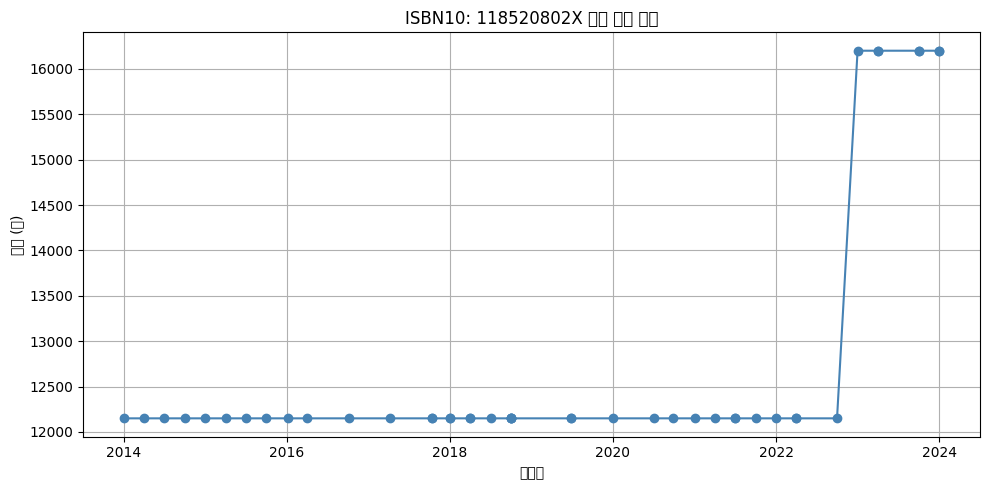

In [403]:
# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(10, 5))
plt.plot(book_history_sorted1['Ï∂úÌåêÏùº'], book_history_sorted1['Í∞ÄÍ≤©'], marker='o', color='steelblue')
plt.title("ISBN10: 118520802X Í∞ÄÍ≤© Î≥ÄÌôî Ï∂îÏù¥")
plt.xlabel("Ï∂úÌåêÏùº")
plt.ylabel("Í∞ÄÍ≤© (Ïõê)")
plt.grid(True)
plt.tight_layout()
plt.show()

Ïû¨Ï∂úÌåêÏù¥ ÎêòÎ©¥ÏÑú Í∞ÄÍ≤©Ïù¥ ÏÉÅÏäπÌñàÎã§. ÌïòÏßÄÎßå ÏïΩ 10ÎÖÑÍ∞Ñ Í∞ÄÍ≤© ÏÉÅÏäπÏù¥ 1Î≤à ÏûàÏóàÍ∏∞ÎïåÎ¨∏Ïóê Ï±Ö Í∞ÄÍ≤©ÏùÑ ÏâΩÍ≤å Ïò¨Î¶¨ÏßÄÎäî ÏïäÎäîÎã§Îäî Í≤ÉÏùÑ Ïïå Ïàò ÏûàÎã§.

`-` Ï†úÎ™©Ïù¥ Îã§Î•∏ ISBN ÏÇ¨Î°Ä `20053657`

In [396]:
isbn_target = "20053657"
book_history2 = merged_df[merged_df['ISBN10'] == isbn_target].copy()
book_history_sorted2 = book_history2.sort_values(by='Ï∂úÌåêÏùº')
book_history_sorted2['Ï∂úÌåêÏùº'] = pd.to_datetime(book_history_sorted2['Ï∂úÌåêÏùº'], format="%YÎÖÑ %mÏõî %dÏùº", errors='coerce')
book_history_sorted2

ÌååÏùºÍ≤ΩÎ°ú  Ïπ¥ÌÖåÍ≥†Î¶¨                Ï†úÎ™©     Ï†ÄÏûê  \
2568    001001001001007/book_3142355.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2008-2009    Ìé∏ÏßëÎ∂Ä   
2766    001001001001007/book_4381252.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2010-2011  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2384    001001001001007/book_6661345.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2012-2013  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2973   001001001001007/book_15401587.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2014-2015  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2680   001001001001007/book_23451586.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2015-2016  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2072   001001001001007/book_34764176.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2016-2017  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2839   001001001001007/book_57555998.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2017-2018  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2769   001001001001007/book_68676710.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2018-2019  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2690   001001001001007/book_84782141.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2019-2020  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2240   001001001001007/book_95932232.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2020-2021  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2894  001001001001007/book_105423862.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2021-2022  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2120  001001001001007/book_116579367.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2022-2023  Ìé∏ÏßëÎ∂Ä Ï†Ä   
2904  001001001001007/book_124861779.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2023-2024  Ìé∏ÏßëÎ∂Ä Ï†Ä   
1857  001001001001007/book_141518096.html  ÏöîÎ¶¨ÏùºÎ∞ò  ÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2024-2025  Î∞ïÏû¨ÏÑù Ï†Ä   

           Ï∂úÌåêÏÇ¨        Ï∂úÌåêÏùº  Î≥ÑÏ†ê      Í∞ÄÍ≤©      Ï™ΩÏàò           Ï±ÖÌÅ¨Í∏∞  \
2568    ÎÜçÏàòÏ∂ïÏÇ∞Ïã†Î¨∏ 2008-10-30   0  120000    999Ï™Ω        2,468g   
2766    ÎÜçÏàòÏ∂ïÏÇ∞Ïã†Î¨∏ 2010-11-10   0  120000    588Ï™Ω        1,910g   
2384     HNCOM 2012-11-10   0  120000    590Ï™Ω  188*254*35mm   
2973     HNCOM 2014-11-15   0  120000  1,059Ï™Ω  184*257*60mm   
2680     HNCOM 2015-11-25   0  120000    967Ï™Ω  192*265*40mm   
2072     HNCOM 2016-11-25  10  120000  1,048Ï™Ω  190*256*60mm   
2839     HNCOM 2017-11-28   0  120000  1,213Ï™Ω  188*255*60mm   
2769     HNCOM 2018-12-05   0  120000  1,263Ï™Ω  188*257*60mm   
2690     HNCOM 2019-12-02   0  120000  1,401Ï™Ω  188*257*80mm   
2240     HNCOM 2020-12-02   0  120000  1,333Ï™Ω  188*257*80mm   
2894     HNCOM 2021-11-30   0  120000  1,364Ï™Ω     190*265mm   
2120  THEBUYER 2022-11-30   0  120000  1,110Ï™Ω  190*265*60mm   
2904  THEBUYER 2023-11-29   0  120000  1,364Ï™Ω  188*260*80mm   
1857      ÎçîÎ∞îÏù¥Ïñ¥ 2024-12-15   0  120000  1,285Ï™Ω  188*256*60mm   

                                                    Ï±ÖÏÜåÍ∞ú  \
2568  ÏãùÌíà ÏÇ∞ÏóÖ Ïó∞Í∞êÎ°ù. ÌïúÍµ≠ ÏãùÌíà ÏÇ∞ÏóÖÏùò ÏóÖÏ¢ÖÎ≥Ñ ÌòÑÌô© Î∞è Ï†ÑÎßùÍ≥º ÏãùÌíàÏù∏Îì§ÏóêÍ≤å ÌïÑÏöîÌïú Í¥Ä...   
2766  „ÄéÌïúÍµ≠ÏãùÌíàÏó∞Í∞ê 2011„Äè. ÏãùÌíà ÏÇ∞ÏóÖ Ïó∞Í∞êÎ°ù. ÌïúÍµ≠ ÏãùÌíà ÏÇ∞ÏóÖÏùò ÏóÖÏ¢ÖÎ≥Ñ ÌòÑÌô© Î∞è Ï†Ñ...   
2384  Ïö∞Î¶¨ÎÇòÎùº ÏãùÌíàÏÇ∞ÏóÖÏùò ÌòÑÌô©Í≥º Ï†ÑÎßùÏùÑ ÌïúÎààÏóê ÌååÏïÖÌï† Ïàò ÏûàÎäî Ïó∞Í∞ê. Ïö∞Î¶¨ ÏãùÌÉÅÏùÑ Ï±ÖÏûÑÏßÄ...   
2973  Ïö∞Î¶¨ÎÇòÎùº ÏãùÌíàÏÇ∞ÏóÖÏùò ÌòÑÌô©Í≥º Ï†ÑÎßùÏùÑ ÌïúÎààÏóê ÌååÏïÖÌï† Ïàò ÏûàÎäî Ïó∞Í∞ê. Ïö∞Î¶¨ ÏãùÌÉÅÏùÑ Ï±ÖÏûÑÏßÄ...   
2680  Ïö∞Î¶¨ÎÇòÎùº ÏãùÌíàÏÇ∞ÏóÖÏùò ÌòÑÌô©Í≥º Ï†ÑÎßùÏùÑ ÌïúÎààÏóê ÌååÏïÖÌï† Ïàò ÏûàÎäî Ïó∞Í∞ê. Ïö∞Î¶¨ ÏãùÌÉÅÏùÑ Ï±ÖÏûÑÏßÄ...   
2072                                               None   
2839                                               None   
2769                                               None   
2690                                               None   
2240                                               None   
2894                                               None   
2120                                               None   
2904                                               None   
1857                                               None   

                                                     Î™©Ï∞®  ÌåêÎß§ÏßÄÏàò         ISBN13  \
2568                                               None  None  9772005365705   
2766                                               Non

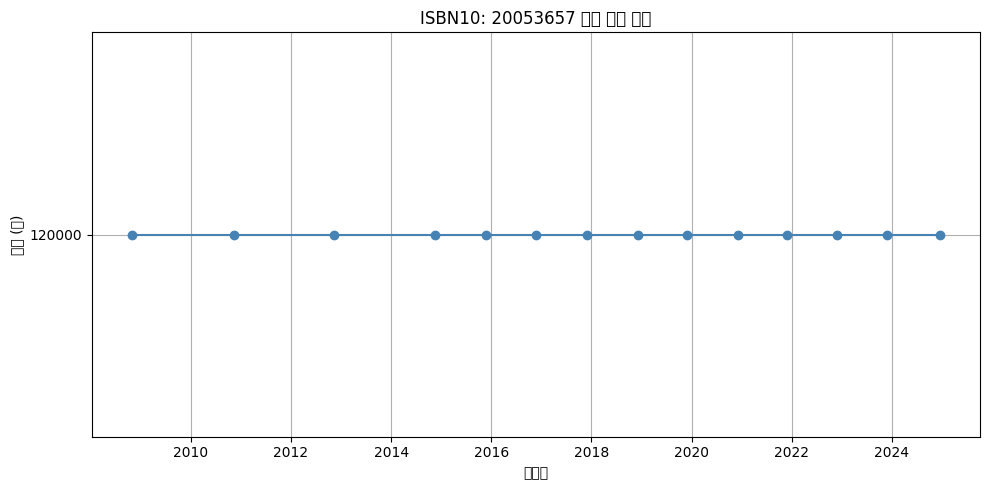

In [405]:
# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(10, 5))
plt.plot(book_history_sorted2['Ï∂úÌåêÏùº'], book_history_sorted2['Í∞ÄÍ≤©'], marker='o', color='steelblue')
plt.title("ISBN10: 20053657 Í∞ÄÍ≤© Î≥ÄÌôî Ï∂îÏù¥")
plt.xlabel("Ï∂úÌåêÏùº")
plt.ylabel("Í∞ÄÍ≤© (Ïõê)")
plt.grid(True)
plt.tight_layout()
plt.show()

Ïó≠Ïãú Ïù¥ Ï±Ö ÎòêÌïú 16ÎÖÑÍ∞Ñ Ï±Ö Í∞ÄÍ≤©Ïù¥ ÎèôÍ≤∞Î°ú Ï±Ö Í∞ÄÍ≤©Ïù¥ ÏâΩÍ≤å Ïò§Î•¥ÏßÄ ÏïäÎäîÎã§Îäî Í≤ÉÏùÑ Î≥¥Ïó¨Ï§ÄÎã§.

`-` Í≤∞Î°†: Ï±Ö Í∞ÄÍ≤©ÏùÄ Ïû¨Ï∂úÌåêÏãúÏóê ÏâΩÍ≤å Ïò¨Î¶¨ÏßÄ ÏïäÎäîÎã§.

In [ ]:
---

## 3-2. Î∞∞ÏÜ°Î£å

`-` **Data**

In [411]:
df['Î∞∞ÏÜ°Î£å'].value_counts()

Î∞∞ÏÜ°Î£å
2,500Ïõê    16281
Î¨¥Î£åÎ∞∞ÏÜ°       8772
3,000Ïõê        1
Name: count, dtype: int64

`-` **Resonance**

3000ÏõêÏù¥ ÏûàÍ∏¥ ÌïòÏßÄÎßå ÎåÄÌëúÏ†ÅÏúºÎ°ú Î¨¥Î£åÎ∞∞ÏÜ°, 2500ÏõêÏúºÎ°ú ÎÇòÎâúÎã§. Ïñ¥Îñ§ Í∏∞Ï§ÄÍ∞ôÏùÄ Í≤å ÏûàÏùÑÍπå?

In [434]:
price1 = df[df['Î∞∞ÏÜ°Î£å'] == '2,500Ïõê']['Í∞ÄÍ≤©'].str.replace('Ïõê', '').str.replace(',', '').astype(int)
price1.describe()

count    16281.000000
mean     10806.088692
std       2787.109710
min        900.000000
25%       8910.000000
50%      11520.000000
75%      13320.000000
max      16000.000000
Name: Í∞ÄÍ≤©, dtype: float64

In [433]:
price2 = df[df['Î∞∞ÏÜ°Î£å'] == 'Î¨¥Î£åÎ∞∞ÏÜ°']['Í∞ÄÍ≤©'].str.replace('Ïõê', '').str.replace(',', '').astype(int)
price2.describe()

count      8772.000000
mean      23649.394665
std       15998.428563
min        5000.000000
25%       16200.000000
50%       18900.000000
75%       25200.000000
max      475000.000000
Name: Í∞ÄÍ≤©, dtype: float64

`-` Ï±Ö Í∞ÄÍ≤©Ïù¥ ÎÜíÏúºÎ©¥ Î¨¥Î£åÎ∞∞ÏÜ°Ïù∏ Í≤ΩÌñ•Ïù¥ ÏûàÎã§.

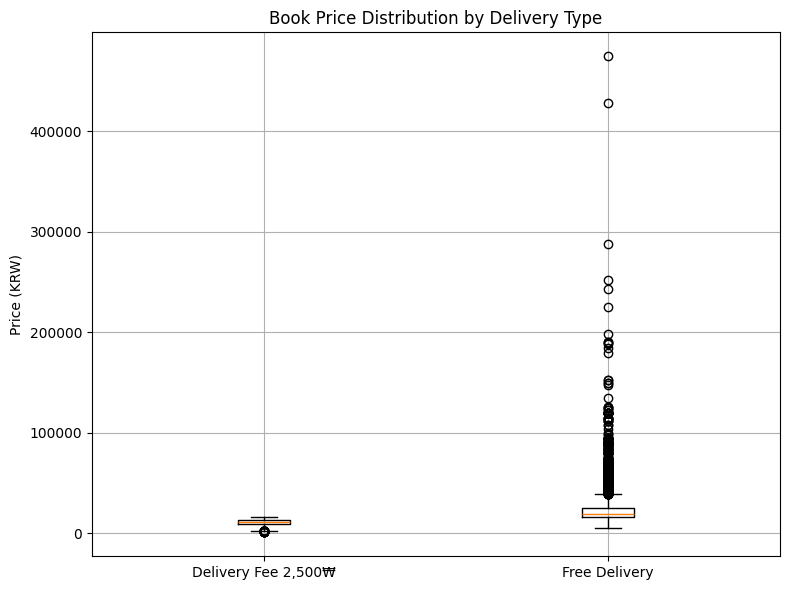

In [437]:
# Boxplot with English labels
plt.figure(figsize=(8, 6))
plt.boxplot([price1, price2], labels=["Delivery Fee 2,500‚Ç©", "Free Delivery"])
plt.ylabel("Price (KRW)")
plt.title("Book Price Distribution by Delivery Type")
plt.grid(True)
plt.tight_layout()
plt.show()

`-` Problem: Í∑∏Îüº ÏñºÎßàÎ∂ÄÌÑ∞ Î∞∞ÏÜ°ÎπÑÍ∞Ä 2500ÏõêÏù∏ÏßÄÍ∞Ä Í∂ÅÍ∏àÌïòÎã§

/tmp/ipykernel_245015/75160784.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Î∞∞ÏÜ°Î≥ÑÎπÑÏú® = df.groupby(['Í∞ÄÍ≤©Íµ¨Í∞Ñ', 'Î∞∞ÏÜ°Î£å']).size().unstack().fillna(0)


<Axes: xlabel='Í∞ÄÍ≤©Íµ¨Í∞Ñ'>

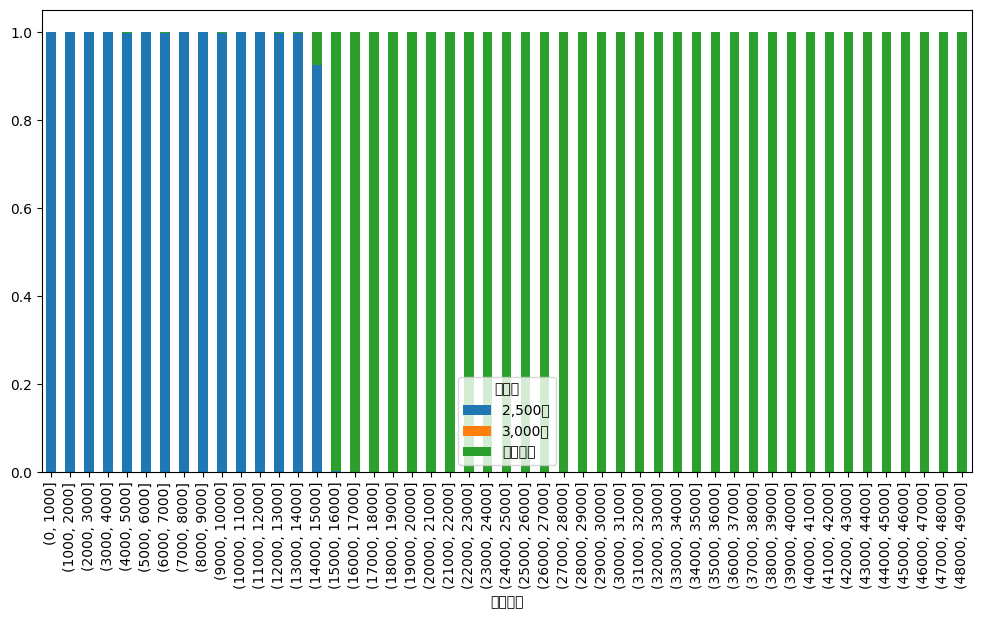

In [440]:
df['Í∞ÄÍ≤©_int'] = df['Í∞ÄÍ≤©'].str.replace('Ïõê', '').str.replace(',', '').astype(float)
bins = list(range(0, 50000, 1000))
df['Í∞ÄÍ≤©Íµ¨Í∞Ñ'] = pd.cut(df['Í∞ÄÍ≤©_int'], bins)
Î∞∞ÏÜ°Î≥ÑÎπÑÏú® = df.groupby(['Í∞ÄÍ≤©Íµ¨Í∞Ñ', 'Î∞∞ÏÜ°Î£å']).size().unstack().fillna(0)
(Î∞∞ÏÜ°Î≥ÑÎπÑÏú®.T / Î∞∞ÏÜ°Î≥ÑÎπÑÏú®.sum(axis=1)).T.plot(kind='bar', stacked=True, figsize=(12,6))

`-` Í≤∞Î°† : ÎåÄÎûµ 14800ÏõêÏ†ïÎèÑ Ïù¥ÏÉÅÏù¥Î©¥ 2500Ïõê Ïù¥ÏÉÅÏù¥Îã§.

---

## 3-3. Ï∂úÌåêÏÇ¨ Î∏åÎûúÎìú Ïã†Î¢∞ÎèÑ Î∂ÑÏÑù

Ïó¨Îü¨ Ïπ¥ÌÖåÍ≥†Î¶¨ÏóêÏÑú Ï∂úÌåêÌïòÎäî Ï∂úÌåêÏÇ¨Í∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏Ìï¥Î¥§Îã§.

In [228]:
# ÌèâÍ∑†Î≥ÑÏ†ê 0Ï†ê Ïù¥ÏÉÅ ÌïÑÌÑ∞ÎßÅ
high_rated = filtered_pub_rating_df[filtered_pub_rating_df['ÌèâÍ∑†Î≥ÑÏ†ê'] >= 0]

# Ï∂úÌåêÏÇ¨Î≥ÑÎ°ú Î™á Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨ÏóêÏÑú 8Ï†ê Ïù¥ÏÉÅÏù∏ÏßÄ count
high_rated_counts = (
    high_rated.groupby('Ï∂úÌåêÏÇ¨')
    .agg(Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò=('Ïπ¥ÌÖåÍ≥†Î¶¨', 'nunique'))
    .reset_index()
    .sort_values('Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò', ascending=False)
)

# ÌïÑÏöîÌïòÎ©¥ Ìï¥Îãπ Ï∂úÌåêÏÇ¨Îì§Ïùò ÌèâÍ∑†Î≥ÑÏ†ê/Ïπ¥ÌÖåÍ≥†Î¶¨ÎèÑ Ìï®Íªò Î≥¥Í∏∞ ÏúÑÌï¥ merge
high_rated_merged = pd.merge(high_rated_counts, high_rated, on='Ï∂úÌåêÏÇ¨')
high_rated_merged[high_rated_merged['Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò'] == 11]

Ï∂úÌåêÏÇ¨  Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò      ÌèâÍ∑†Î≥ÑÏ†ê  Î¶¨Î∑∞Í∞úÏàò       Ïπ¥ÌÖåÍ≥†Î¶¨
0   Î¶¨Ïä§Ïª¥     11  9.266667    12     Ï∞®/Ïà†/ÏùåÎ£å
1   Î¶¨Ïä§Ïª¥     11  9.306250    16       ÏöîÎ¶¨ÏùºÎ∞ò
2   Î¶¨Ïä§Ïª¥     11  9.398649    74       ÏÉùÌôúÏöîÎ¶¨
3   Î¶¨Ïä§Ïª¥     11  9.407317    41      Í∞úÏù∏ÏöîÎ¶¨Ï±Ö
4   Î¶¨Ïä§Ïª¥     11  9.200000    59      ÏÉÅÌô©Î≥ÑÏöîÎ¶¨
5   Î¶¨Ïä§Ïª¥     11  9.168750    48  Î©îÎâ¥Î≥Ñ/ÎÇòÎùºÎ≥ÑÏöîÎ¶¨
6   Î¶¨Ïä§Ïª¥     11  9.233333    24  ÌôàÎ≤†Ïù¥ÌÇπ/Î≤†Ïù¥Ïª§Î¶¨
7   Î¶¨Ïä§Ïª¥     11  9.576923    13      ÏûÑÏã†/Ï∂úÏÇ∞
8   Î¶¨Ïä§Ïª¥     11  9.560000    15         Ïú°ÏïÑ
9   Î¶¨Ïä§Ïª¥     11  9.341667    12       ÏûêÎÖÄÍµêÏú°
10  Î¶¨Ïä§Ïª¥     11  9.457895    19       Ïßë/ÏÇ¥Î¶º

In [229]:
# ÌèâÍ∑†Î≥ÑÏ†ê 0Ï†ê Ïù¥ÏÉÅ ÌïÑÌÑ∞ÎßÅ
high_rated = filtered_pub_rating_df[filtered_pub_rating_df['ÌèâÍ∑†Î≥ÑÏ†ê'] >= 0]

# Ï∂úÌåêÏÇ¨Î≥ÑÎ°ú Î™á Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨ÏóêÏÑú 8Ï†ê Ïù¥ÏÉÅÏù∏ÏßÄ count
high_rated_counts = (
    high_rated.groupby('Ï∂úÌåêÏÇ¨')
    .agg(Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò=('Ïπ¥ÌÖåÍ≥†Î¶¨', 'nunique'))
    .reset_index()
    .sort_values('Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò', ascending=False)
)

# ÌïÑÏöîÌïòÎ©¥ Ìï¥Îãπ Ï∂úÌåêÏÇ¨Îì§Ïùò ÌèâÍ∑†Î≥ÑÏ†ê/Ïπ¥ÌÖåÍ≥†Î¶¨ÎèÑ Ìï®Íªò Î≥¥Í∏∞ ÏúÑÌï¥ merge
high_rated_merged = pd.merge(high_rated_counts, high_rated, on='Ï∂úÌåêÏÇ¨')
high_rated_merged[high_rated_merged['Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò'] == 7]

Ï∂úÌåêÏÇ¨  Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò      ÌèâÍ∑†Î≥ÑÏ†ê  Î¶¨Î∑∞Í∞úÏàò       Ïπ¥ÌÖåÍ≥†Î¶¨
11              Í∑∏Î¶∞Ïø°      7  9.538462    13     Ï∞®/Ïà†/ÏùåÎ£å
12              Í∑∏Î¶∞Ïø°      7  9.470000    10       ÏöîÎ¶¨ÏùºÎ∞ò
13              Í∑∏Î¶∞Ïø°      7  9.284211    19       ÏÉùÌôúÏöîÎ¶¨
14              Í∑∏Î¶∞Ïø°      7  9.338889    18      Í∞úÏù∏ÏöîÎ¶¨Ï±Ö
15              Í∑∏Î¶∞Ïø°      7  8.876923    13      ÏÉÅÌô©Î≥ÑÏöîÎ¶¨
16              Í∑∏Î¶∞Ïø°      7  9.177143    35  Î©îÎâ¥Î≥Ñ/ÎÇòÎùºÎ≥ÑÏöîÎ¶¨
17              Í∑∏Î¶∞Ïø°      7  9.303333    30  ÌôàÎ≤†Ïù¥ÌÇπ/Î≤†Ïù¥Ïª§Î¶¨
18            ÎèôÏïÑÏùºÎ≥¥ÏÇ¨      7  8.787500    16       ÏÉùÌôúÏöîÎ¶¨
19            ÎèôÏïÑÏùºÎ≥¥ÏÇ¨      7  8.910000    10      Í∞úÏù∏ÏöîÎ¶¨Ï±Ö
20            ÎèôÏïÑÏùºÎ≥¥ÏÇ¨      7  9.130769    13      ÏÉÅÌô©Î≥ÑÏöîÎ¶¨
21            ÎèôÏïÑÏùºÎ≥¥ÏÇ¨      7  8.920000    10  ÌôàÎ≤†Ïù¥ÌÇπ/Î≤†Ïù¥Ïª§Î¶¨
22            ÎèôÏïÑÏùºÎ≥¥ÏÇ¨      7  8.990909    11         Ïú°ÏïÑ
23            ÎèôÏïÑÏùºÎ≥¥ÏÇ¨      7  9.007692    13       ÏûêÎÖÄÍµêÏú°
24            ÎèôÏïÑÏùºÎ≥¥ÏÇ¨      7  8.873333    15       Ïßë/ÏÇ¥Î¶º
25  ÎπÑÌÉÄÎ∂ÅÏä§(VITABOOKS)      7  9.452381    21       ÏÉùÌôúÏöîÎ¶¨
26  ÎπÑÌÉÄÎ∂ÅÏä§(VITABOOKS)      7  9.263636    11      Í∞úÏù∏ÏöîÎ¶¨Ï±Ö
27  ÎπÑÌÉÄÎ∂ÅÏä§(VITABOOKS)      7  9.471875    32      ÏÉÅÌô©Î≥ÑÏöîÎ¶¨
28  ÎπÑÌÉÄÎ∂ÅÏä§(VITABOOKS)      7  9.316667    12  Î©îÎâ¥Î≥Ñ/ÎÇòÎùºÎ≥ÑÏöîÎ¶¨
29  ÎπÑÌÉÄÎ∂ÅÏä§(VITABOOKS)      7  9.456250    16  ÌôàÎ≤†Ïù¥ÌÇπ/Î≤†Ïù¥Ïª§Î¶¨
30  ÎπÑÌÉÄÎ∂ÅÏä§(VITABOOKS)      7  9.560000    10         Ïú°ÏïÑ
31  ÎπÑÌÉÄÎ∂ÅÏä§(VITABOOKS)      7  9.536364    11       ÏûêÎÖÄÍµêÏú°

`-` Resonance

Ïùë? ÎåÄÎ∂ÄÎ∂Ñ ÌèâÏ†êÏù¥ ÏóÑÏ≤≠ ÎÜíÎÑ§?

In [227]:
# Ï∂úÌåêÏÇ¨Î≥Ñ Î≥ÑÏ†ê Ï†ÄÏû• Î¶¨Ïä§Ìä∏
publisher_ratings = []

for cat, df in dfs_rated.items():
    temp = df.copy()
    
    # Ï∂úÌåêÏÇ¨ Í≤∞Ï∏° Ï†úÍ±∞ Î∞è Ï†ïÎ¶¨
    temp = temp[temp['Ï∂úÌåêÏÇ¨'].notnull()]
    
    # Ï∂úÌåêÏÇ¨Î≥Ñ ÌèâÍ∑† Î≥ÑÏ†ê Í≥ÑÏÇ∞
    grp = temp.groupby('Ï∂úÌåêÏÇ¨')['Î≥ÑÏ†ê'].agg(['mean', 'count']).reset_index()
    grp['Ïπ¥ÌÖåÍ≥†Î¶¨'] = cat  # Ïπ¥ÌÖåÍ≥†Î¶¨ Ï†ïÎ≥¥ Ï∂îÍ∞Ä
    
    publisher_ratings.append(grp)

# Î™®Îì† Ïπ¥ÌÖåÍ≥†Î¶¨ ÌÜµÌï©
pub_rating_df = pd.concat(publisher_ratings, ignore_index=True)

# Ïù¥Î¶Ñ Ï†ïÎ¶¨
pub_rating_df.columns = ['Ï∂úÌåêÏÇ¨', 'ÌèâÍ∑†Î≥ÑÏ†ê', 'Î¶¨Î∑∞Í∞úÏàò', 'Ïπ¥ÌÖåÍ≥†Î¶¨']

# Î¶¨Î∑∞ Ïàò 10Í∞ú Ïù¥ÏÉÅÎßå ÌïÑÌÑ∞ÎßÅ (Ïã†Î¢∞ÏÑ± ÌôïÎ≥¥)
filtered_pub_rating_df = pub_rating_df[pub_rating_df['Î¶¨Î∑∞Í∞úÏàò'] >= 10]

# ÌèâÍ∑†Î≥ÑÏ†ê ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨
pub_rating_sorted = filtered_pub_rating_df.sort_values("ÌèâÍ∑†Î≥ÑÏ†ê", ascending=False)

pub_rating_sorted

Ï∂úÌåêÏÇ¨      ÌèâÍ∑†Î≥ÑÏ†ê  Î¶¨Î∑∞Í∞úÏàò       Ïπ¥ÌÖåÍ≥†Î¶¨
5085           Ï≤¥Ïù∏ÏßÄÏóÖ  9.900000    12       ÏûêÎÖÄÍµêÏú°
4705            ÏãúÎåÄÏù∏  9.885714    14       ÏûêÎÖÄÍµêÏú°
3613            ÏãúÎåÄÏù∏  9.869231    13         Ïú°ÏïÑ
4304  ÎèôÏñëÎ∂ÅÏä§(ÎèôÏñëbooks)  9.866667    18       ÏûêÎÖÄÍµêÏú°
4267           ÎçîÎ©îÏù¥Ïª§  9.841667    12       ÏûêÎÖÄÍµêÏú°
...             ...       ...   ...        ...
739           ÌÅ¥ÎùºÏù¥ÎãâÏä§  7.760000    10       ÏöîÎ¶¨ÏùºÎ∞ò
2127     IFAD(Ïù¥ÌîÑÏï†Îìú)  7.477273    22  ÌôàÎ≤†Ïù¥ÌÇπ/Î≤†Ïù¥Ïª§Î¶¨
5731          Ï§ëÏïôm&b  7.421429    14       Ïßë/ÏÇ¥Î¶º
5585          ÏÑúÏö∏Î¨∏ÌôîÏÇ¨  6.875000    12       Ïßë/ÏÇ¥Î¶º
1626          ÏÑúÏö∏Î¨∏ÌôîÏÇ¨  6.872727    11      ÏÉÅÌô©Î≥ÑÏöîÎ¶¨

[343 rows x 4 columns]

`-` Insight

Îã§ÏñëÌïú Ïπ¥ÌÖåÍ≥†Î¶¨ÏóêÏÑú Ï∂úÌåêÌïòÎäî Ï∂úÌåêÏÇ¨Îì§Ïù¥ ÌèâÏ†êÏù¥ ÎåÄÏ≤¥Ï†ÅÏúºÎ°ú ÎÜíÎã§.

In [185]:
# ÌèâÍ∑†Î≥ÑÏ†ê 8Ï†ê Ïù¥ÏÉÅ ÌïÑÌÑ∞ÎßÅ
high_rated = filtered_pub_rating_df[filtered_pub_rating_df['ÌèâÍ∑†Î≥ÑÏ†ê'] >= 8]

# Ï∂úÌåêÏÇ¨Î≥ÑÎ°ú Î™á Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨ÏóêÏÑú 8Ï†ê Ïù¥ÏÉÅÏù∏ÏßÄ count
high_rated_counts = (
    high_rated.groupby('Ï∂úÌåêÏÇ¨')
    .agg(Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò=('Ïπ¥ÌÖåÍ≥†Î¶¨', 'nunique'))
    .reset_index()
    .sort_values('Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò', ascending=False)
)

# ÌïÑÏöîÌïòÎ©¥ Ìï¥Îãπ Ï∂úÌåêÏÇ¨Îì§Ïùò ÌèâÍ∑†Î≥ÑÏ†ê/Ïπ¥ÌÖåÍ≥†Î¶¨ÎèÑ Ìï®Íªò Î≥¥Í∏∞ ÏúÑÌï¥ merge
high_rated_merged = pd.merge(high_rated_counts, high_rated, on='Ï∂úÌåêÏÇ¨')
eleven_df = high_rated_merged[high_rated_merged['Ïπ¥ÌÖåÍ≥†Î¶¨Ïàò'] >= 5]
eleven_df.groupby('Ï∂úÌåêÏÇ¨').agg({'ÌèâÍ∑†Î≥ÑÏ†ê':'mean'}).reset_index()

Ï∂úÌåêÏÇ¨      ÌèâÍ∑†Î≥ÑÏ†ê
0             Í≤ΩÌñ•ÎØ∏ÎîîÏñ¥  9.483405
1              Í≤ΩÌñ•ÎπÑÌîº  9.626501
2              Í∑∏Î¶¨Í≥†Ï±Ö  9.161116
3               Í∑∏Î¶∞Ïø°  9.284137
4                Í∏∏Î≤ó  9.621711
5               ÎÇòÎ¨¥Ïàò  9.319587
6             ÎèôÏïÑÏùºÎ≥¥ÏÇ¨  8.945743
7        Î†àÏãúÌîºÌå©ÌÜ†Î¶¨(Îã®Ìñâ)  9.682654
8               Î¶¨Ïä§Ïª¥  9.356132
9                ÎØ∏Ìò∏  9.092096
10  ÎπÑÌÉÄÎ∂ÅÏä§(VITABOOKS)  9.436739
11            ÏÇºÏÑ±Ï∂úÌåêÏÇ¨  8.784775
12              ÏÑ±ÏïàÎãπ  8.978692
13             ÏòÅÏßÑÎã∑Ïª¥  8.986863
14      Ï§ëÏïôÎ∂ÅÏä§(books)  9.243517
15            ÌïúÏä§ÎØ∏ÎîîÏñ¥  9.302106

`-` Ï∂úÌåêÏÇ¨Ïùò ÌíàÏßà Î≥¥Ï¶ù

Îã®ÏàúÌïú Ïù∏Í∏∞ Ï±ÖÏù¥ ÏïÑÎãàÎùº, Íæ∏Ï§ÄÌïú ÎßåÏ°±ÏùÑ ÎßåÎì§Ïñ¥ÎÇ¥Îäî Ï†úÏûë ÏãúÏä§ÌÖúÏù¥ ÏûàÏùåÏùÑ Ï¶ùÎ™ÖÌï©ÎãàÎã§.

---

## 3-4. ÎèÑÏÑú Ï†ïÎ≥¥Î°ú Î≥¥Îäî ÏÇ¨ÌöåÌòÑÏÉÅ ÌÉêÍµ¨

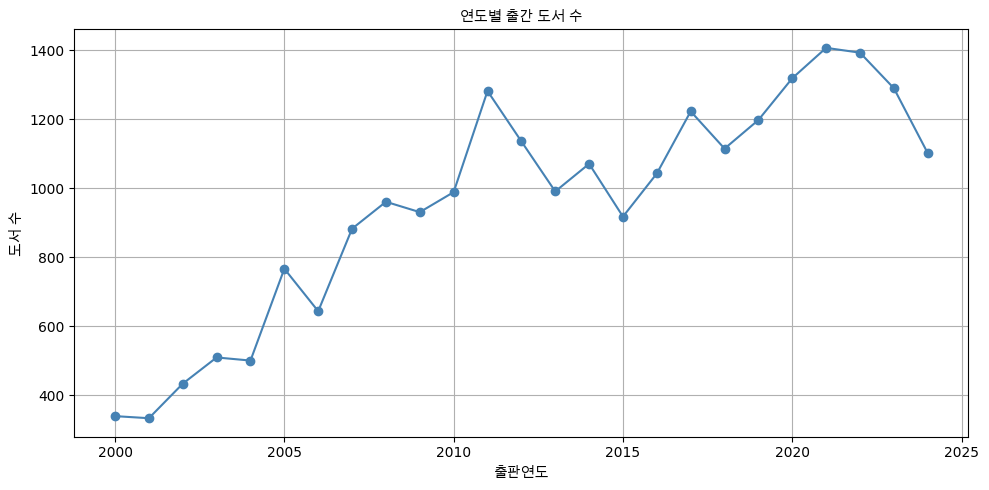

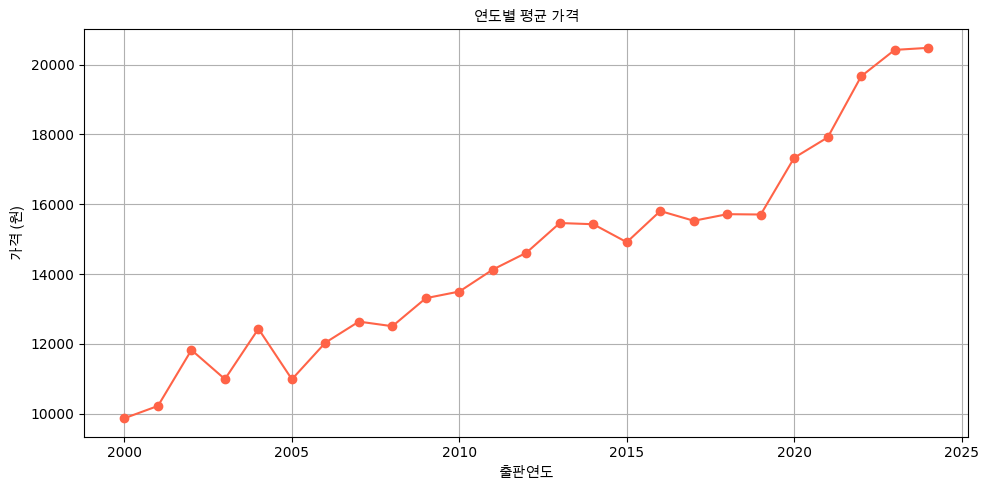

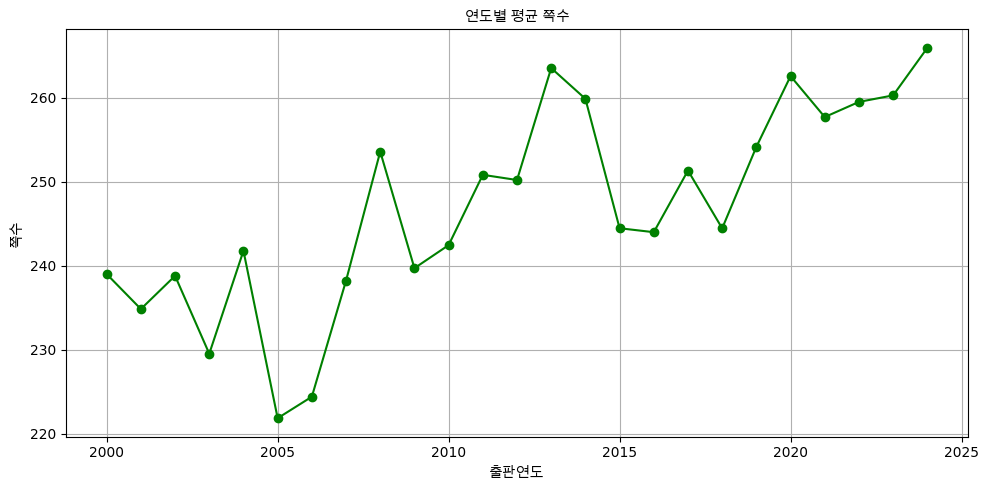

In [232]:
# suppress font logs
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# ‚úÖ Ìè∞Ìä∏ ÏÑ§Ï†ï
font_path = "./Arial Unicode.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# ‚úÖ ÌÜµÌï© Ï†ÑÏ≤òÎ¶¨
records = []

for cat, df in dfs_grouped.items():
    df = df.copy()
    df['Ï∂úÌåêÏó∞ÎèÑ'] = df['Ï∂úÌåêÏùº'].astype(str).str.extract(r'(\d{4})')[0]
    df['Ï∂úÌåêÏó∞ÎèÑ'] = pd.to_numeric(df['Ï∂úÌåêÏó∞ÎèÑ'], errors='coerce')
    df['Í∞ÄÍ≤©'] = pd.to_numeric(df['Í∞ÄÍ≤©'].astype(str).str.replace(",", "").str.replace("Ïõê", ""), errors='coerce')
    df['Ï™ΩÏàò'] = pd.to_numeric(df['Ï™ΩÏàò'].astype(str).str.extract(r'(\d+)')[0], errors='coerce')

    # Ï±Ö Î©¥Ï†Å Ï∂îÏ∂ú
    def calc_area(text):
        try:
            parts = text.replace("mm", "").split("*")
            if len(parts) >= 2:
                return int(parts[0]) * int(parts[1])
        except:
            return None
        return None

    df['Ï±ÖÎ©¥Ï†Å'] = df['Ï±ÖÌÅ¨Í∏∞'].astype(str).apply(calc_area)
    df['Ïπ¥ÌÖåÍ≥†Î¶¨'] = cat
    records.append(df[['Ï∂úÌåêÏó∞ÎèÑ', 'Í∞ÄÍ≤©', 'Ï™ΩÏàò', 'Ï±ÖÎ©¥Ï†Å', 'Ïπ¥ÌÖåÍ≥†Î¶¨']])

combined_df = pd.concat(records, ignore_index=True)
combined_df = combined_df.dropna(subset=['Ï∂úÌåêÏó∞ÎèÑ'])
combined_df['Ï∂úÌåêÏó∞ÎèÑ'] = combined_df['Ï∂úÌåêÏó∞ÎèÑ'].astype(int)
# ‚úÖ 2000ÎÖÑ Ïù¥ÌõÑ, 2025ÎÖÑ Ï†úÏô∏
combined_df = combined_df[(combined_df['Ï∂úÌåêÏó∞ÎèÑ'] >= 2000) & (combined_df['Ï∂úÌåêÏó∞ÎèÑ'] != 2025)]


# ‚úÖ Ïó∞ÎèÑÎ≥Ñ ÏßëÍ≥Ñ
trend_df = (
    combined_df
    .groupby('Ï∂úÌåêÏó∞ÎèÑ')
    .agg({
        'Í∞ÄÍ≤©': 'mean',
        'Ï™ΩÏàò': 'mean',
        'Ï±ÖÎ©¥Ï†Å': 'mean',
        'Ïπ¥ÌÖåÍ≥†Î¶¨': 'count'  # Ï∂úÍ∞Ñ ÎèÑÏÑú Ïàò
    })
    .rename(columns={'Ïπ¥ÌÖåÍ≥†Î¶¨': 'Ï∂úÍ∞ÑÎèÑÏÑúÏàò'})
    .reset_index()
)

# ‚úÖ ÏãúÍ∞ÅÌôî Ìï®Ïàò
def plot_trend(x, y, title, ylabel, color):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, marker='o', color=color)
    plt.title(title, fontproperties=font_prop)
    plt.xlabel("Ï∂úÌåêÏó∞ÎèÑ", fontproperties=font_prop)
    plt.ylabel(ylabel, fontproperties=font_prop)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ‚úÖ Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plot_trend(trend_df['Ï∂úÌåêÏó∞ÎèÑ'], trend_df['Ï∂úÍ∞ÑÎèÑÏÑúÏàò'], "Ïó∞ÎèÑÎ≥Ñ Ï∂úÍ∞Ñ ÎèÑÏÑú Ïàò", "ÎèÑÏÑú Ïàò", 'steelblue')
plot_trend(trend_df['Ï∂úÌåêÏó∞ÎèÑ'], trend_df['Í∞ÄÍ≤©'], "Ïó∞ÎèÑÎ≥Ñ ÌèâÍ∑† Í∞ÄÍ≤©", "Í∞ÄÍ≤© (Ïõê)", 'tomato')
plot_trend(trend_df['Ï∂úÌåêÏó∞ÎèÑ'], trend_df['Ï™ΩÏàò'], "Ïó∞ÎèÑÎ≥Ñ ÌèâÍ∑† Ï™ΩÏàò", "Ï™ΩÏàò", 'green')

`-` 2020ÎÖÑ Ïù¥ÌõÑ Ï∂úÌåê ÎèÑÏÑú Ïàò Í∞êÏÜåÏùò ÏõêÏù∏
1. ÏΩîÎ°úÎÇò19 Ìå¨Îç∞ÎØπ
- Í≥µÍ∏âÎßù Ï∂©Í≤©: Ï¢ÖÏù¥ Î∂ÄÏ°±, Ïù∏ÏáÑÏÜå Ïö¥ÏòÅ Ï∞®Ïßà Îì±ÏúºÎ°ú Î¨ºÎ¶¨Ï†Å Ï∂úÌåê ÏßÄÏó∞
- Ï∂úÌåêÏÇ¨ Ïö¥ÏòÅ Ï∂ïÏÜå: ÏÜåÍ∑úÎ™® Ï∂úÌåêÏÇ¨ÎÇò ÎèÖÎ¶Ω Ï∂úÌåêÏùò ÌôúÎèôÏù¥ ÏúÑÏ∂ï
- Ïã†Í∞Ñ Í∏∞Ìöç Ï§ëÎã®: Ï∂úÌåê ÏóÖÍ≥Ñ Ï†ÑÎ∞òÏùò Î∂àÌôïÏã§ÏÑ± Ï¶ùÍ∞Ä -> Ïã†Í∞Ñ Í≥ÑÌöç Ï∂ïÏÜå
2. Ï†ÑÏûêÏ±Ö Î∞è Ïò§ÎîîÏò§Î∂Å ÌôïÏÇ∞
- Ï¢ÖÏù¥Ï±Ö Ï∂úÍ∞ÑÏùÄ Ï§ÑÏóàÏßÄÎßå, ÎîîÏßÄÌÑ∏ ÏΩòÌÖêÏ∏†Î°ú ÎåÄÏ≤¥ÎêòÎäî Í≤ΩÌñ•
3. ÎèÑÏÑúÏ†ïÍ∞ÄÏ†ú Í∞úÏ†ï Ïù¥Ïäà
- Ìï†Ïù∏ Ï†úÌïú Îì±ÏúºÎ°ú ÎèÑÏÑú ÏãúÏû• ÏúÑÏ∂ï -> Ïã†Í∞Ñ Ï∂úÌåê Î∂ÄÎã¥ Ï¶ùÍ∞Ä

`-` Ï™ΩÏàò Î≥ÄÌôî

1. 2000ÎÖÑÎåÄ Ïù¥Ï†Ñ: ÌèâÍ∑† Ï™ΩÏàòÏùò ÌÅ∞ Î≥ÄÎèô
- Îç∞Ïù¥ÌÑ∞ ÏàòÍ∞Ä Ï†ÅÏñ¥ÏÑú Î≥ÄÎèôÏù¥ Ïã¨ÌïòÎã§.
2. 2000ÎÖÑÎåÄ Ïù¥ÌõÑ: ÌèâÍ∑† Ï™ΩÏàòÍ∞Ä 230~270Ï™Ω Î≤îÏúÑÏóêÏÑú ÏÑúÏÑúÌûà Ï¶ùÍ∞ÄÏ§ëÏù¥Îã§.
- ÎîîÏßÄÌÑ∏ ÏãúÎåÄÏóê Ïò§ÌûàÎ†§ Îçî ÌíçÎ∂ÄÌïú Ï†ïÎ≥¥ Ï†úÍ≥µÏù¥ÎÇò ÏãúÎ¶¨Ï¶àÎ¨º Í≤ΩÌñ•ÏúºÎ°ú Ï™ΩÏàòÍ∞Ä ÎäòÏñ¥ÎÇú Í≤ÉÏúºÎ°ú Ï∂îÏ†ï.

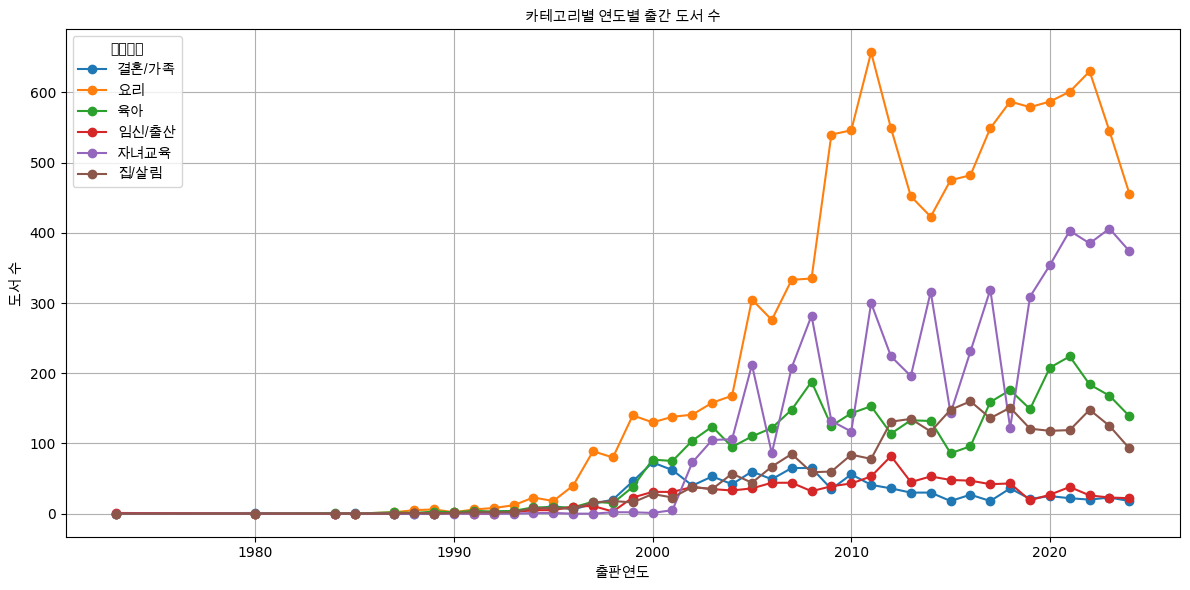

In [230]:
# ‚úÖ Ïó∞ÎèÑÎ≥Ñ Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÎèÑÏÑú Ïàò ÏßëÍ≥Ñ
category_year_counts = (
    combined_df
    .groupby(['Ï∂úÌåêÏó∞ÎèÑ', 'Ïπ¥ÌÖåÍ≥†Î¶¨'])
    .size()
    .reset_index(name='ÎèÑÏÑúÏàò')
)

# ‚úÖ ÌîºÎ≤ó ÌÖåÏù¥Î∏îÎ°ú Î≥ÄÌôò: index=Ïó∞ÎèÑ, columns=Ïπ¥ÌÖåÍ≥†Î¶¨
pivot_df = category_year_counts.pivot(index='Ï∂úÌåêÏó∞ÎèÑ', columns='Ïπ¥ÌÖåÍ≥†Î¶¨', values='ÎèÑÏÑúÏàò').fillna(0)

# ‚úÖ ÏãúÍ∞ÅÌôî: Ïó¨Îü¨ Ïπ¥ÌÖåÍ≥†Î¶¨ ÏÑ† Í∑∏ÎûòÌîÑ
plt.figure(figsize=(12, 6))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], marker='o', label=col)

plt.title("Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Ïó∞ÎèÑÎ≥Ñ Ï∂úÍ∞Ñ ÎèÑÏÑú Ïàò", fontproperties=font_prop)
plt.xlabel("Ï∂úÌåêÏó∞ÎèÑ", fontproperties=font_prop)
plt.ylabel("ÎèÑÏÑú Ïàò", fontproperties=font_prop)
plt.legend(title="Ïπ¥ÌÖåÍ≥†Î¶¨", prop=font_prop, loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**2023ÎÖÑ Ïù¥ÌõÑÎ°ú ÏßÄÍ∏àÍπåÏßÄ Ï∂úÍ∞Ñ ÎèÑÏÑúÏùò ÏàòÎäî Í∏âÍ∞êÏ§ëÏù¥Îã§.**

1. Ï∂úÌåê ÏãúÏû•Ïùò ÏúÑÏ∂ï: ÎîîÏßÄÌÑ∏ ÏΩòÌÖêÏ∏† ÏÜåÎπÑÎ°ú Ï†ÑÌôò
2. Ï∂úÌåêÏÇ¨ Íµ¨Ï°∞Ï°∞Ï†ïÍ≥º ÌèêÏóÖ Ï¶ùÍ∞Ä -> Ïã§Ï†úÎ°ú 2023 ~ 2024ÎÖÑ ÌïúÍµ≠ Ï∂úÌåêÏÇ¨ Îì±Î°ù ÏàòÎäî Ï§ÑÍ≥† ÏûàÏùå.
3. ÏÜåÎπÑÏûê Ïã¨Î¶¨ Î≥ÄÌôî -> ÏΩîÎ°úÎÇò Ïù¥ÌõÑ ÎèÖÏÑú Í¥ÄÏã¨ Ïù¥ÌÉà

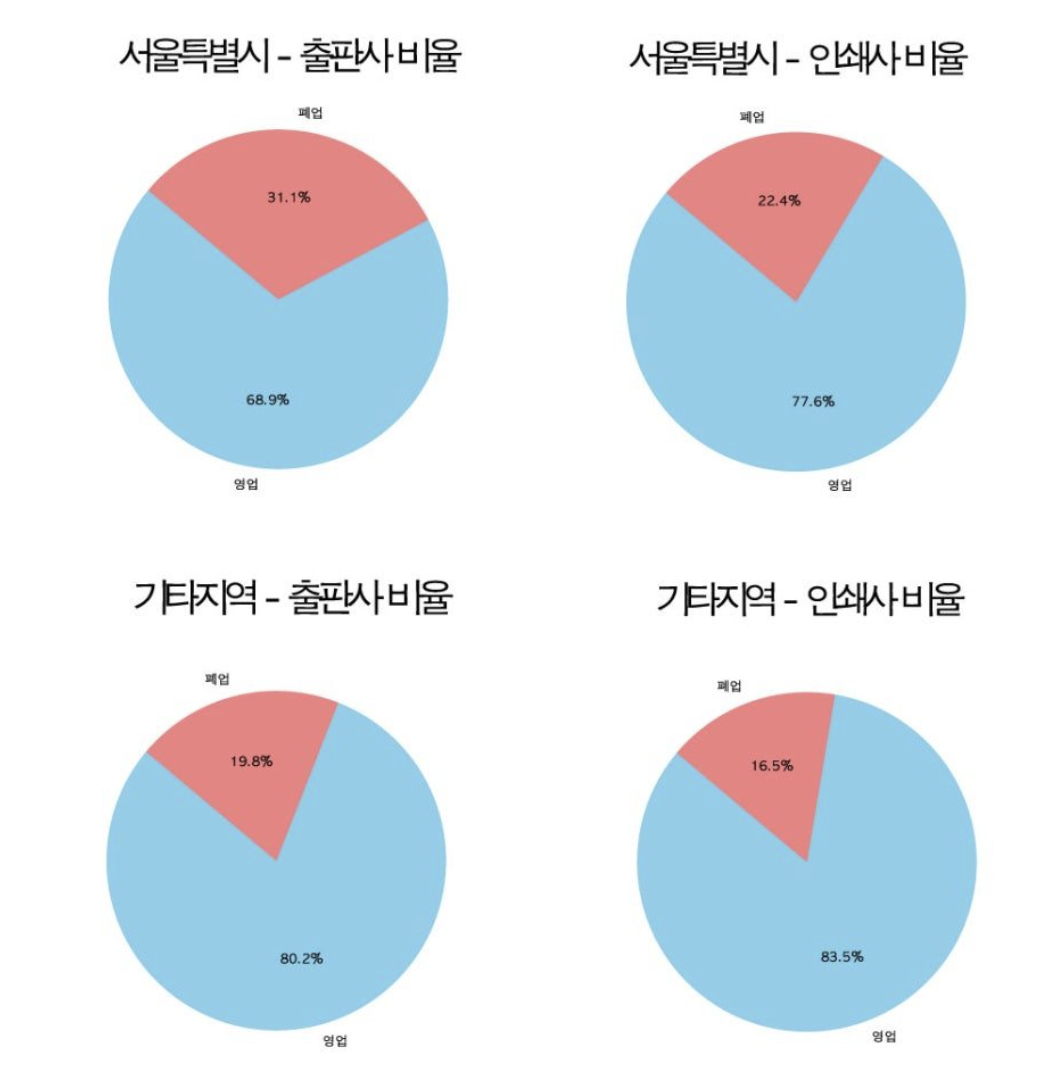

**2005ÎÖÑ ~ 2010ÎÖÑ ÏöîÎ¶¨ ÎèÑÏÑú Ï∂úÍ∞Ñ Í∏âÏ¶ùÏùò Ïù¥Ïú†**

1. Ïõ∞Îπô Ìä∏Î†åÎìúÏôÄ Í±¥Í∞ïÏóê ÎåÄÌïú Í¥ÄÏã¨ Ï¶ùÍ∞Ä
2. ÏöîÎ¶¨ Í¥ÄÎ†® TV ÌîÑÎ°úÍ∑∏Îû®Ïù¥ Ïù∏Í∏∞Î•º ÎÅåÎ©¥ÏÑú ÏöîÎ¶¨Ïóê ÎåÄÌïú ÎåÄÏ§ëÏùò Í¥ÄÏã¨Ïù¥ ÎÜíÏïÑÏ°åÎã§.

**Ï±Ö Í∞ÄÍ≤©Ïù¥ Íæ∏Ï§ÄÌûà Ïò§Î•¥Îäî Ïù¥Ïú†**

1. Ïù∏ÌîåÎ†àÏù¥ÏÖò
 - ÌïúÍµ≠ÏùÄÌñâ ÏÜåÎπÑÏûêÎ¨ºÍ∞Ä(CPI) Í∏∞Ï§Ä 2000ÎÖÑ ÎåÄÎπÑ 2023ÎÖÑ ÏïΩ 35~40% ÏÉÅÏäπ
 - Ï±ÖÍ∞íÏùÄ Ïã§Ï†úÎ°ú ÏïΩ 2Î∞∞Ï†ïÎèÑ Ïò¨ÎûêÎäîÎç∞ Ïù¥Í≤ÉÎßåÏúºÎ°úÎäî ÏÑ§Î™ÖÎêòÏßÄ ÏïäÎäîÎã§.
2. Ï±ÖÏùò Íµ¨ÏÑ± Î≥ÄÌôî
 - Ïª¨Îü¨ Ïù∏ÏáÑ / ÏÇ¨ÏßÑ Ï§ëÏã¨ Íµ¨ÏÑ± -> Ï†úÏûë Îã®Í∞Ä ÏÉÅÏäπ -> Ï†ïÍ∞Ä ÏÉÅÏäπ
 - Í≥†Í∏â Ï†úÎ≥∏ -> ÏñëÏû• or Ï¢ÖÏù¥Î•º Îçî Ï¢ãÏùÄ Í≤ÉÏùÑ ÏÇ¨Ïö© -> ÌåêÎß§Í∞Ä Ïù∏ÏÉÅ
 - Ìå®ÌÇ§ÏßÄ Íµ¨ÏÑ± -> Ï±Ö + ÏõåÌÅ¨Î∂Å + Ïπ¥Îìú Îì± ÏÑ∏Ìä∏Ìôî Í≤ΩÌñ• Ï¶ùÍ∞Ä
3. ÌÉÄÍ≤ü ÎèÖÏûê Î≥ÄÌôî
 - ÏöîÎ¶¨/ÏûêÎÖÄÍµêÏú°/ÌôàÎ≤†Ïù¥ÌÇπÏùÄ ÎåÄÏ§ë Ï†ÑÏ≤¥Í∞Ä ÏïÑÎãå `Î™∞ÏûÖ ÎèÖÏûê` Ï§ëÏã¨ ÌåêÎß§
 - Ï∂úÌåêÏÇ¨Îäî ÎåÄÎüâÎ≥¥Îã§Îäî Í≥†Ï†ï Íµ¨Îß§Ï∏µÏùÑ ÏúÑÌïú ÌîÑÎ¶¨ÎØ∏ÏóÑ Ï†ÑÎûµÏùÑ Ï∑®Ìï®
4. Ï∂úÍ∞Ñ Ïàò Í∞êÏÜåÎ°ú Ïù∏Ìïú Îã®Í∞Ä ÏÉÅÏäπ
 - Ï∂úÌåêÏÇ¨Îäî Ï†ÑÏ≤¥ ÌåêÎß§ÎüâÏù¥ Ï§ÑÍ≥† ÏûàÍ∏∞Ïóê ÏàòÏùµÏùÑ ÎßûÏ∂îÍ∏∞ ÏúÑÌï¥ Í∂åÎãπ Í∞ÄÍ≤©ÏùÑ Ïò¨Î¶¨Îäî Í≤ΩÌñ•Ïù¥ ÏûàÏùå

**Ï±ÖÏùò ÌéòÏù¥ÏßÄ ÏàòÍ∞Ä ÎäòÏñ¥ÎÇòÎäî Ïù¥Ïú†**

1. ÍπäÏù¥ ÏûàÎäî Ï±ÖÏóê ÎåÄÌïú ÏàòÏöî ÏßëÏ§ë
 - ÎîîÏßÄÌÑ∏ ÏΩòÌÖêÏ∏†ÏóêÏÑú ÏñïÏùÄ ÏßÄÏãùÏùÄ Ï∂©Î∂ÑÌûà ÏñªÏùÑ Ïàò ÏûàÍ≤å ÎêòÎØÄÎ°ú Îèà Ï£ºÍ≥† ÏÇ¨Îäî Ï±ÖÏùÄ **ÍπäÏù¥ ÏûàÍ≤å ÏÑ§Î™ÖÌïòÎäî Ï±Ö**Ïù¥ ÎêòÏñ¥ÏïºÌïúÎã§.
2. Ï†ÄÏûê Ï§ëÏã¨ ÏΩòÌÖêÏ∏† Í∞ïÌôî -> ÏûêÏ†ÑÏ†Å ÏÑúÏà† Ï¶ùÍ∞Ä
 - Ï†ÑÎ¨∏Í∞Ä Î∏åÎûúÎî©ÏùÑ ÏúÑÌï¥ÏÑú Ìïú Í∂å ÏïàÏóê Í≤ΩÌóò + Ìï¥ÏÑù + ÌåÅ + FAQ + ÏπºÎüºÍπåÏßÄ Îã§ ÎÑ£Îã§Î≥¥Îãà ÌéòÏù¥ÏßÄ ÏàòÍ∞Ä ÎäòÏñ¥ÎÇ®
 - Ïã§Ï†úÎ°ú ÏöîÎ¶¨Ï±ÖÎèÑ ÏöîÏ¶òÏùÄ Î†àÏãúÌîºÎ≥¥Îã§ ÏÑúÏÇ¨ Ï§ëÏã¨ Íµ¨ÏÑ±Ïù¥ ÎßéÏùå
3. Ìé∏Ïßë Ìä∏Î†åÎìú Î≥ÄÌôî
 - ÎèÖÏÑú ÌîºÎ°úÎèÑÎ•º Ï§ÑÏù¥Í∏∞ ÏúÑÌï¥ Ìé∏ÏßëÏù¥ ÎÑìÏùÄ Ïó¨Î∞± + ÌÅ∞ Í∏ÄÏûê + ÎßéÏùÄ ÏÇ¨ÏßÑ Ï§ëÏã¨ÏúºÎ°ú Î≥ÄÌôî
 - Ïù¥Î°ú Ïù∏Ìï¥ Î¨ºÎ¶¨Ï†Å Ï™ΩÏàòÎäî ÎäòÏñ¥ÎÇòÏßÄÎßå Ïã§Ï†ú ÌÖçÏä§Ìä∏ ÏñëÏùÄ ÎπÑÏä∑Ìï† Ïàò ÏûàÏùå

---

## 3-5. ÏûêÎÖÄÍµêÏú°Ïùò ÌèâÍ∑† ÌéòÏù¥ÏßÄ Ï¶ùÍ∞Ä

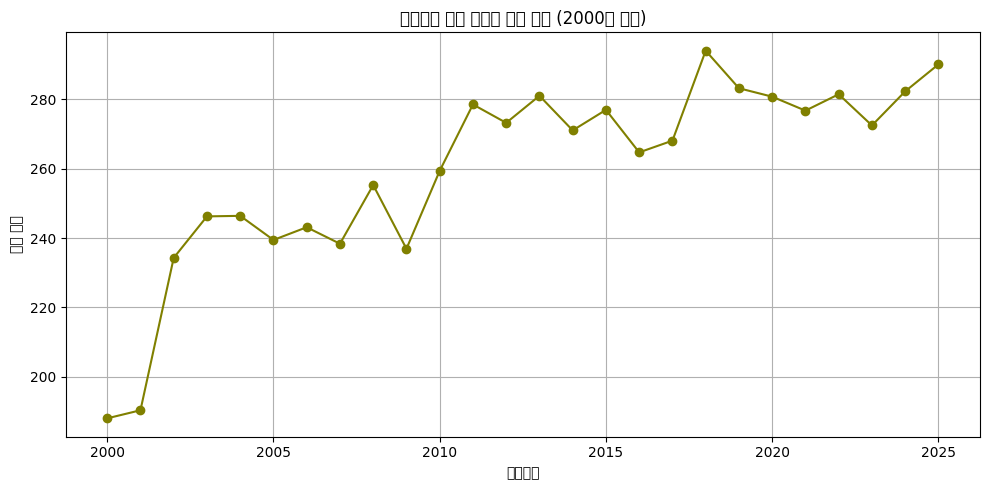

In [210]:
# suppress font logs
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

import matplotlib.font_manager as fm
font_path = "Arial Unicode.ttf"
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

df = dfs_renamed['ÏûêÎÖÄÍµêÏú°'].copy()

# Ï∂úÌåêÏó∞ÎèÑ Ï∂îÏ∂ú
df['Ï∂úÌåêÏó∞ÎèÑ'] = df['Ï∂úÌåêÏùº'].astype(str).str.extract(r'(\d{4})')[0].astype(float)

# Ï™ΩÏàò Ïà´ÏûêÎ°ú Î≥ÄÌôò
df['Ï™ΩÏàò'] = df['Ï™ΩÏàò'].astype(str).str.extract(r'(\d+)')[0].astype(float)

# ‚úÖ 2000ÎÖÑ Ïù¥ÌõÑ ÎèÑÏÑúÎßå ÌïÑÌÑ∞ÎßÅ
df = df[df['Ï∂úÌåêÏó∞ÎèÑ'] >= 2000]

# Ïó∞ÎèÑÎ≥Ñ ÌèâÍ∑† Ï™ΩÏàò ÏßëÍ≥Ñ
trend = df.groupby('Ï∂úÌåêÏó∞ÎèÑ')['Ï™ΩÏàò'].mean().reset_index()

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 5))
plt.plot(trend['Ï∂úÌåêÏó∞ÎèÑ'], trend['Ï™ΩÏàò'], marker='o', color='olive')
plt.title("ÏûêÎÖÄÍµêÏú° Î∂ÑÏïº Ïó∞ÎèÑÎ≥Ñ ÌèâÍ∑† Ï™ΩÏàò (2000ÎÖÑ Ïù¥ÌõÑ)")
plt.xlabel("Ï∂úÌåêÏó∞ÎèÑ")
plt.ylabel("ÌèâÍ∑† Ï™ΩÏàò")
plt.grid(True)
plt.tight_layout()
plt.show()

üìö ÏûêÎÖÄÍµêÏú°ÏÑú ÌèâÍ∑† ÌéòÏù¥ÏßÄ Ï¶ùÍ∞ÄÍ∞Ä ÏãúÏÇ¨ÌïòÎäî Í≤É
1. Î∂ÄÎ™®Îì§Ïùò Ï†ïÎ≥¥ ÏöïÍµ¨ Ï¶ùÍ∞Ä
ÌòÑÎåÄ ÏÇ¨ÌöåÏóêÏÑú Î∂ÄÎ™®Îì§ÏùÄ Îçî ÎßéÏùÄ Ï†ïÎ≥¥Î•º Î∞îÌÉïÏúºÎ°ú ÏûêÎÖÄÎ•º ÏñëÏú°ÌïòÎ†§Îäî Í≤ΩÌñ•Ïù¥ Í∞ïÌï¥Ï°åÏäµÎãàÎã§.

ÍµêÏú° Î∞©Ïãù, Îáå Î∞úÎã¨, Ïã¨Î¶¨Ìïô, ÏßÑÎ°ú, ÎîîÏßÄÌÑ∏ Î¶¨ÌÑ∞Îü¨Ïãú Îì± Îã§ÏñëÌïú ÌïòÏúÑ Ï£ºÏ†úÍ∞Ä Ìè¨Ìï®ÎêòÎ©∞ Ï±ÖÏùò Î∂ÑÎüâÎèÑ ÏûêÏó∞Ïä§ÎüΩÍ≤å Ï¶ùÍ∞ÄÌï©ÎãàÎã§.

2. ÏñëÏú°Ïùò Ï†ÑÎ¨∏Ìôî¬∑ÏÑ∏Î∂ÑÌôî
Í≥ºÍ±∞ÏóêÎäî 'ÌõàÏú°'Ïù¥ÎÇò 'ÏÉùÌôú ÏäµÍ¥Ä' Ï§ëÏã¨Ïù¥Îçò ÍµêÏú°ÏÑúÍ∞Ä,

ÏßÄÍ∏àÏùÄ Î∞úÎã¨ Ïã¨Î¶¨, Ïñ∏Ïñ¥ ÏûêÍ∑π, Í∞êÏ†ï ÏΩîÏπ≠, Ï∞ΩÏùòÏÑ± ÍµêÏú°, ÏΩîÎî©ÍµêÏú° Îì± Îã§ÏñëÌïú Î∂ÑÏïºÎ°ú ÏÑ∏Î∂ÑÌôî.

Ïù¥Î°ú Ïù∏Ìï¥ 1Í∂åÏóê Îã¥ÏïÑÏïº Ìï† Ï†ïÎ≥¥ÎüâÏù¥ ÎßéÏïÑÏßÄÍ≥†, ÌéòÏù¥ÏßÄ ÏàòÎèÑ ÎäòÏñ¥ÎÇ©ÎãàÎã§.

3. Ï∂úÌåê Í≤ΩÌñ•Ïùò Î≥ÄÌôî
ÏãúÎ¶¨Ï¶àÍ∞Ä ÏïÑÎãå Îã®Í∂å ÏôÑÍ≤∞Ìòï Ï¢ÖÌï© ÍµêÏú°ÏÑúÍ∞Ä ÎäòÏñ¥ÎÇòÎäî Ï∂îÏÑ∏Ïùº Ïàò ÏûàÏùå.

ÏòàÏ†ÑÏóî ÏñáÏùÄ Ï±Ö Ïó¨Îü¨ Í∂åÏù¥Îçò Í≤ÉÏù¥, ÏöîÏ¶òÏùÄ ÎëêÍ∫ºÏö¥ Ï¢ÖÌï©ÏÑúÎ°ú ÌÜµÌï©ÎêòÎäî Íµ¨Ï°∞.

4. ÏÇ¨ÌöåÏ†Å Î∂àÏïàÍ≥º Í≤ΩÏüÅ Ïã¨Ìôî
ÍµêÏú° ÌôòÍ≤ΩÏù¥ Í≤ΩÏüÅÏ†ÅÏúºÎ°ú Î≥ÄÌïòÎ©¥ÏÑú, Î∂ÄÎ™®Îäî Îçî ÎßéÏùÄ ÎåÄÎπÑÎ•º ÌïòÎ†§ Ìï®.

Ïòà: Ï°∞Í∏∞ÍµêÏú°, ÏÇ¨ÍµêÏú°, ÏßÑÌïô Ï†ÑÎûµ Îì± Î≥µÏû°Ìï¥ÏßÑ ÍµêÏú° ÌòÑÏã§ÏùÑ Î∞òÏòÅ.

5. ÎîîÏßÄÌÑ∏ ÏãúÎåÄÏóê Ïò§ÌûàÎ†§ Í∞ïÌôîÎêú 'ÌôúÏûê ÍµêÏú°' ÏΩòÌÖêÏ∏†
ÏïÑÏù¥Î•º ÎîîÏßÄÌÑ∏ ÎØ∏ÎîîÏñ¥Î°úÎ∂ÄÌÑ∞ ÏßÄÌÇ§Í∏∞ ÏúÑÌï¥, Î∂ÄÎ™®Îäî Ï±Ö Ï§ëÏã¨Ïùò ÍµêÏú° ÏΩòÌÖêÏ∏†Î•º Îçî ÏÑ†Ìò∏Ìï®.

Îî∞ÎùºÏÑú Ïò§ÌîÑÎùºÏù∏ ÏΩòÌÖêÏ∏†Ïùò ÍπäÏù¥ÏôÄ Ïã†Î¢∞ÏÑ± ÌôïÎ≥¥Î•º ÏúÑÌï¥ ÎëêÍ∫ºÏõåÏßÄÎäî Í≤ΩÌñ•ÎèÑ ÏûàÏùå.

---

## 3-6. ÏûêÎÖÄÍµêÏú° Ï±ÖÏùÄ 2000ÎÖÑ Ïù¥Ï†ÑÏóê 6Í∂åÎ∞ñÏóê ÏóÜÎã§?

In [233]:
df = dfs_renamed['ÏûêÎÖÄÍµêÏú°'].copy()

# Ï∂úÌåêÏó∞ÎèÑ Ï∂îÏ∂ú
df['Ï∂úÌåêÏó∞ÎèÑ'] = df['Ï∂úÌåêÏùº'].astype(str).str.extract(r'(\d{4})')[0]
df['Ï∂úÌåêÏó∞ÎèÑ'] = pd.to_numeric(df['Ï∂úÌåêÏó∞ÎèÑ'], errors='coerce')

# Ï†ÑÏ≤¥ ÎèÑÏÑú Ïàò
total_count = len(df)

# 2000ÎÖÑ Ïù¥Ï†Ñ ÎèÑÏÑú ÌïÑÌÑ∞ÎßÅ
before_2000_df = df[df['Ï∂úÌåêÏó∞ÎèÑ'] < 2000]
before_2000_count = before_2000_df.shape[0]

# Í≤∞Í≥º Ï∂úÎ†•
print(f"Ï†ÑÏ≤¥ ÎèÑÏÑú Ïàò: {total_count}Í∂å")
print(f"2000ÎÖÑ Ïù¥Ï†Ñ ÎèÑÏÑú Ïàò: {before_2000_count}Í∂å")
print("\nüìö 2000ÎÖÑ Ïù¥Ï†Ñ ÎèÑÏÑú Ï†úÎ™© Î™©Î°ù:")
print(before_2000_df[['Ï∂úÌåêÏó∞ÎèÑ', 'Ï†úÎ™©']].sort_values(by='Ï∂úÌåêÏó∞ÎèÑ'))

Ï†ÑÏ≤¥ ÎèÑÏÑú Ïàò: 5661Í∂å
2000ÎÖÑ Ïù¥Ï†Ñ ÎèÑÏÑú Ïàò: 6Í∂å

üìö 2000ÎÖÑ Ïù¥Ï†Ñ ÎèÑÏÑú Ï†úÎ™© Î™©Î°ù:
        Ï∂úÌåêÏó∞ÎèÑ                      Ï†úÎ™©
2726  1994.0             Ïñ¥Î®∏ÎãàÏùò ÌîºÏïÑÎÖ∏ ÍµêÏú°
19    1995.0                Ïã†ÏÑ∏ÎåÄ Ïã¨Ï∏µÎ∂ÑÏÑù
1492  1998.0           ÏùºÍ∏∞Ïì∞Í∏∞ Ïñ¥ÎñªÍ≤å ÏãúÏûëÌï†Íπå
3223  1998.0  Ïú†ÎåÄÏù∏ÏùÄ EQÎ°ú ÏãúÏûëÌïòÏó¨ IQÎ°ú ÏäπÎ¶¨ÌïúÎã§
1953  1999.0        ÏïÑÏù¥ÏóêÍ≤å ÌñâÎ≥µÏùÑ Ï£ºÎäî ÎπÑÍ≤∞ 1
4157  1999.0        ÏïÑÏù¥ÏóêÍ≤å ÌñâÎ≥µÏùÑ Ï£ºÎäî ÎπÑÍ≤∞ 2


üîç ÏõêÏù∏:
Í≥ºÍ±∞ÏóêÎäî ÏûêÎÖÄÍµêÏú°Ïù¥ ‚ÄòÏ∂úÌåê Ïπ¥ÌÖåÍ≥†Î¶¨‚ÄôÎ°ú ÎöúÎ†∑ÌïòÍ≤å Î∂ÑÎ¶¨ÎêòÏßÄ ÏïäÏùå
‚Üí ÌõàÏú°, Í∞ÄÏ†ïÏÉùÌôú, Í∞ÄÏ†ïÌïô Îì±Ïùò Î≤îÏ£ºÎ°ú Ï°¥Ïû¨ÌñàÏßÄÎßå, ÏßÄÍ∏àÍ≥º Í∞ôÏùÄ Ï†ÑÎ¨∏ÌôîÎêú ÍµêÏú° ÏΩòÌÖêÏ∏†Îäî ÎßéÏßÄ ÏïäÏïòÏùå.

ÏûêÎÖÄÍµêÏú°Ïù¥ ÏÇ¨ÌöåÏ†Å ÌôîÎëêÍ∞Ä Îêú Í≤ÉÏùÄ 2000ÎÖÑÎåÄ Ïù¥ÌõÑ
‚Üí ÏûÖÏãúÍ≤ΩÏüÅ, Ï°∞Í∏∞ÍµêÏú°, Ï∞ΩÏùòÏÑ± ÍµêÏú° Îì± ÌòÑÎåÄÏ†Å Í∞úÎÖêÏù¥ Í∞ïÌôîÎêòÎ©∞ Ìè≠Î∞úÏ†ÅÏúºÎ°ú Ï∂úÌåêÎê®.

Ìå®Îü¨Îã§ÏûÑÏù¥ Îπ†Î•¥Í≤å Î∞îÎÄåÎäî Î∂ÑÏïº
‚Üí ÏãúÎåÄ ÌùêÎ¶ÑÏóê ÎßûÏßÄ ÏïäÎäî Í≥ºÍ±∞ Ï±ÖÏùÄ ÎèÑÌÉúÎêòÍ≥† Ïû¨Ï∂úÍ∞ÑÎêòÏßÄ ÏïäÏùå.